# 💻 Análisis Econométrico 

In [640]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### I Creación Dataset 

In [641]:
# Semilla para reproducibilidad
np.random.seed(42)

# Número de observaciones
n = 100

# Crear DataFrame
df = pd.DataFrame()

# Variables independientes
df['Consumo'] = np.round(np.random.uniform(0, 1000, size=n), 3)
df['Gasto'] = np.round(np.random.uniform(0, 1000, size=n), 3)
df['Inversion'] = np.round(np.random.uniform(0, 1000, size=n), 3)
df['ExportacionesNetas'] = np.round(np.random.uniform(-500, 500, size=n), 3)  # puede ser negativa
df['X1(años)'] = np.random.randint(18, 65, size=n)
df['D1(Género)'] = np.random.choice([0, 1], size=n)

# Coeficientes arbitrarios
coef = {
    'Consumo': 0.3,
    'Gasto': 0.2,
    'Inversion': 0.5,
    'ExportacionesNetas': 0.4,
    'X1(años)': 1.2,
    'D1(Género)': 15
}

# Término de error aleatorio controlado
error = np.random.normal(loc=0, scale=10, size=n)

# Variable dependiente con relación lineal
df['Ingreso(M$)'] = (
    coef['Consumo'] * df['Consumo'] +
    coef['Gasto'] * df['Gasto'] +
    coef['Inversion'] * df['Inversion'] +
    coef['ExportacionesNetas'] * df['ExportacionesNetas'] +
    coef['X1(años)'] * df['X1(años)'] +
    coef['D1(Género)'] * df['D1(Género)'] +
    error
).round(3)

In [642]:
df.head()

,Consumo,Gasto,Inversion,ExportacionesNetas,X1(años),D1(Género),Ingreso(M$)
0,374.540,31.429,642.032,-448.318,58,0,323.779
1,950.714,636.410,84.140,31.355,47,1,552.870
2,731.994,314.356,161.629,40.635,34,0,422.925
3,598.658,508.571,898.554,137.430,37,0,842.286
4,156.019,907.566,606.429,226.091,42,0,674.557


In [643]:
df = df.rename(columns={
    'Ingreso(M$)': 'Ingreso_M',
    'D1(Género)': 'Género',
    'X1(años)': 'Años'
})

In [644]:
df.columns

Index(['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género',
       'Ingreso_M'],
      dtype='object')

###

### Análisis visual previo a diseño de RLM

#### Cálculo residuos 

In [645]:
import statsmodels.api as sm

X = df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']]
y = df['Ingreso_M'] 

X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit() 
residuos = modelo.resid

#### Histograma de residuos ( se observa normalidad de errores)

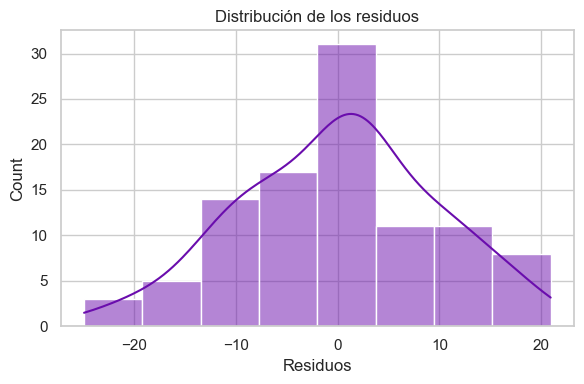

In [646]:
plt.figure(figsize=(6, 4))
sns.histplot(residuos, kde=True, color='#6A0DAD')
plt.title('Distribución de los residuos')
plt.xlabel('Residuos')
plt.grid(True)
plt.tight_layout()
plt.show()


### Gráfica scatter residuos vs valores ajustados

Distribución aleatoria alrededor de cero, sin formar patrones claros.

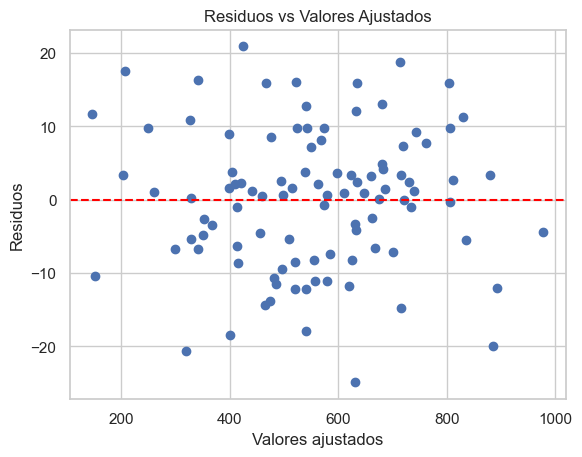

In [647]:
import matplotlib.pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.text import Text

# Residuos vs valores ajustados
valores_ajustados = modelo.fittedvalues
plt.scatter(valores_ajustados, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')

# salida rich
console = Console()

mensaje = Text("Distribución aleatoria alrededor de cero, sin formar patrones claros.")
mensaje.stylize("bold green")  # Puedes usar otros estilos como 'italic', 'underline', o colores distintos
console.print(mensaje)

plt.show()

### Tamaño muestra 

In [648]:
n = len(df)
print(f"Tamaño de muestra: {n}")

Tamaño de muestra: 100

### Histogramas con línea 

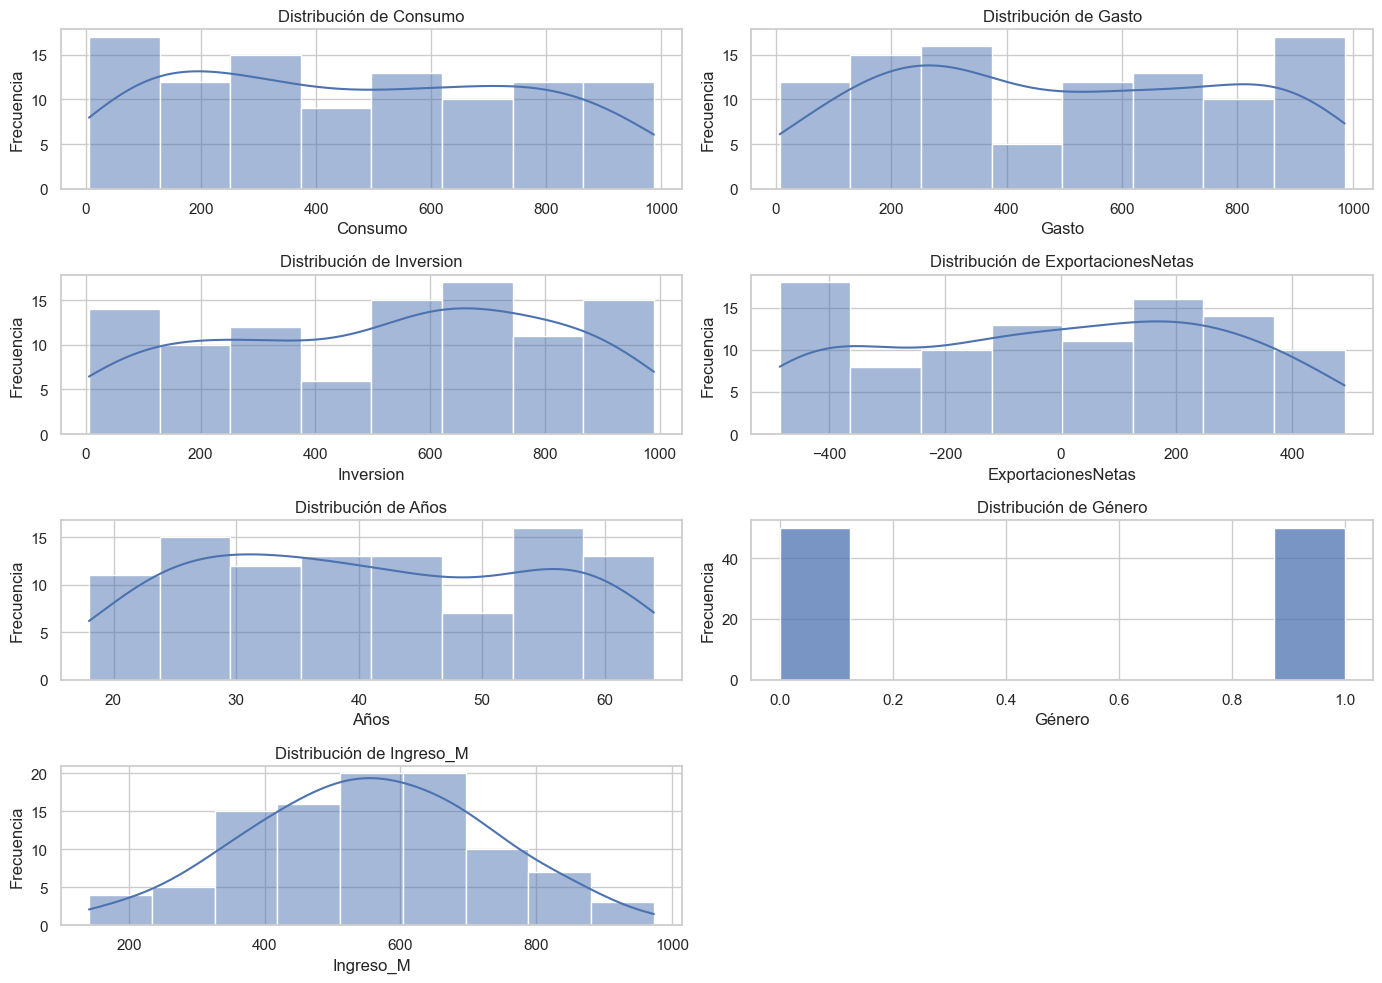

In [649]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables a graficar
variables = ['Consumo','Gasto','Inversion','ExportacionesNetas','Años','Género','Ingreso_M']

# Configurar figura con subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Graficar cada variable
for i, var in enumerate(variables):
    sns.histplot(df[var], kde=True if df[var].nunique() > 2 else False, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

# Ocultar subplot vacío si hay uno
if len(variables) < len(axes):
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### II Metodología de análisis estadístico para modelar regresión lineal multiple 

#### 1) Diagnosis hipotesis iniciales :
     a) normalidad
     b) linealidad
     c) Analisis de homogenidad de varianza (homoscedasticidad)
     d) observaciones independiente
     e) Ausencia multicolinealidad 

#### 🧮 Definir variable

In [650]:
import statsmodels.api as sm

# Variables independientes
X = df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']]
X = sm.add_constant(X)  # Agrega el intercepto

# Variable dependiente
y = df['Ingreso_M'] 

#### a) Análisis de normalidad 

#### 📈Ajustar el modelo

In [651]:
modelo = sm.OLS(y, X).fit()

#### 📊 Extraer residuos

In [652]:
residuos = modelo.resid

#### Prueba de normalidad de D’Agostino y Pearson (prueba de normalidad a los residuos)

In [653]:
from statsmodels.api import OLS
from scipy import stats

#🧠
modelo = sm.OLS(y, X).fit()
residuos = modelo.resid

# Prueba de normalidad
stat, p = stats.normaltest(residuos)
α = 0.05

# Output técnico
print(f"Estadístico K² : {stat:.4f} | con α = {α:.2f} | p-valor: {p:.4f}")

Estadístico K² : 0.6431 | con α = 0.05 | p-valor: 0.7250

🔍 ¿Qué es el estadístico K²?
- Es el resultado de combinar dos pruebas:
- D’Agostino’s test de asimetría (skewness)
- Anscombe-Glynn’s test de curtosis (kurtosis)
- El estadístico K²,mide desviación conjunta de los residuos respecto a lo esperado bajo normalidad.

🧠 Interpretación
- Hipótesis nula (H₀): Residuos provienen de una distribución normal.
- Si p < α , entonces hay evidencia suficiente para rechazar H₀ → los residuos no siguen una distribución normal.
- Si p ≥ α , entonces no se rechaza H₀ → no hay evidencia significativa contra la normalidad.

#### Regla decisión 

In [654]:
from rich.console import Console

# 🧠 Interpretación en consola con Rich
console = Console()

# Decisión basada en p-valor
if p < α:
    console.print("✅ [bold green]Evidencia suficiente para rechazar H₀[/bold green] [yellow]⇒[/yellow] "
                  "los residuos no siguen una distribución normal.", style="bold")
    console.print(f"📊 [green]Estadístico K² = {stat:.4f}[/green] | α = {α:.2f} | [green]p-valor = {p:.4f}[/green]")
else:
    console.print("❌ [bold red]No se rechaza H₀[/bold red] [yellow]⇒[/yellow] "
                  "no hay evidencia significativa contra la normalidad, por lo tanto, se asume normalidad.", style="bold")
    console.print(f"📊 [red] con Estadístico K² = {stat:.4f}[/red] | α = {α:.2f} | [red]p-valor = {p:.4f}[/red]")

❌ No se rechaza H₀ ⇒ no hay evidencia significativa contra la normalidad, por lo tanto, se asume normalidad.

📊  con Estadístico K² = 0.6431 | α = 0.05 | p-valor = 0.7250

#### Gráfico QQ plot , normalidad 

✅ Residuos ≈ línea recta en gráfico Q-Q ⇒ siguen una Normalidad aproximada confirmada .

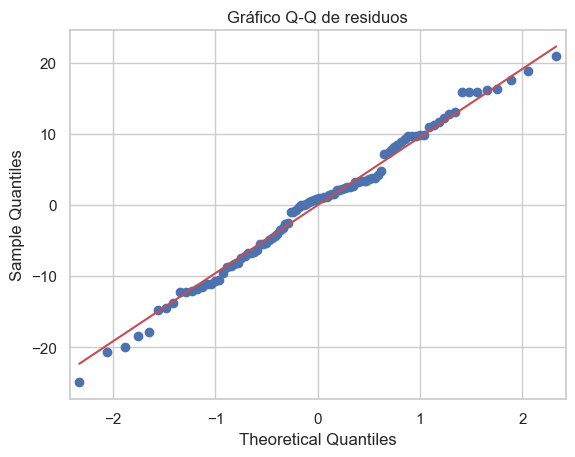

In [655]:
import statsmodels.api as sm
from rich.console import Console

sm.qqplot(residuos, line='s')
plt.title("Gráfico Q-Q de residuos")

console = Console()
console.print("[bold green]✅ Residuos ≈ línea recta en gráfico Q-Q[/bold green] ⇒ siguen una Normalidad aproximada confirmada .", style="cyan")
plt.show()

#### Prueba de Shapiro-Wilk

In [656]:
from scipy import stats

stat_sw, p_sw = stats.shapiro(residuos)
print(f"🔹 Shapiro-Wilk:\n  Estadístico = {stat_sw:.4f}, p-valor = {p_sw:.4f}")

🔹 Shapiro-Wilk:
  Estadístico = 0.9892, p-valor = 0.6014

#### 🧠 Interpretación

- 📌Prueba de normalidad: Shapiro-Wilk : 
- Hipótesis nula (H₀): Los residuos siguen una distribución normal.
- α = 0.05
- Mientas más cercano a 1 sea valor de Estadístico , mejor ajuste normalidad .
- p-valor = 0.6014 → p > α → No se rechaza H₀
- ✅ Conclusión: No hay evidencia suficiente para rechazar H₀.
- Por lo tanto , residuos podrían ser normales según esta prueba y no se viola el supuesto de normalidad.

####

#### Prueba de Kolmogorov-Smirnov

##### 📌 Hipótesis del test K-S
- H₀ : Residuos siguen una distribución normal.
- H₁ : Residuos no siguen una distribución normal.

In [657]:
from scipy import stats
import numpy as np

# Estimar media y desviación estándar de los residuos
mu, sigma = np.mean(residuos), np.std(residuos, ddof=1)

# Aplicar el test de Kolmogorov-Smirnov
ks_stat, ks_p = stats.kstest(residuos, 'norm', args=(mu, sigma))
print(f"🔹 Kolmogorov-Smirnov:\n  Estadístico = {ks_stat:.4f}, p-valor = {ks_p:.4f}")

🔹 Kolmogorov-Smirnov:
  Estadístico = 0.0708, p-valor = 0.6713

#### Interpretación

- Nivel de significancia (α) = 0.05
- p-valor = 0.6713 → p > α → No se rechaza H₀ . p-valor sugiere que diferencia no es estadisticamente significativa , por lo tanto , residuos estan razonalmente cerca de seguir distribución normal .

- ✅ conclusión: Los residuos podrían considerarse normales según esta prueba , Por lo tanto, no se viola el supuesto de normalidad .

#### Gráfico Q-Q Plot :
#### herramienta visual para evaluar si una muestra , en este caso,  los residuos del modelo— sigue una distribución normal.

Si puntos siguen esa línea recta de forma cercana, especialmente en el centro de la distribución, se considera que 
los residuos tienen una distribución aproximadamente normal.

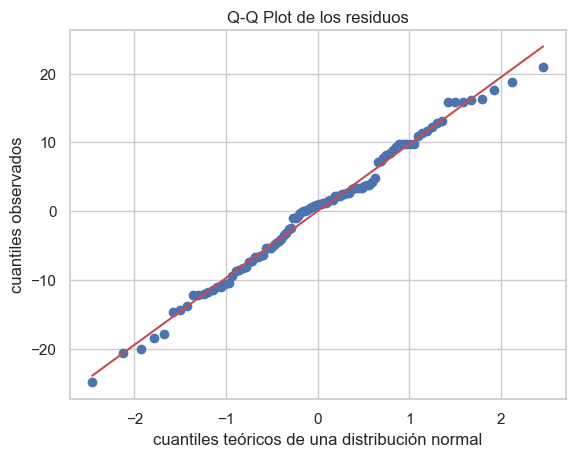

In [658]:
from rich.console import Console

stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q Plot de los residuos")
plt.xlabel("cuantiles teóricos de una distribución normal")
plt.ylabel("cuantiles observados") # cuantiles observados (calculados a partir de tus residuos)
plt.grid(True)

console = Console()
console.print("[bold green]Si puntos siguen esa línea recta de forma cercana,[/bold green] "
              "[italic]especialmente en el centro de la distribución[/italic], "
              "se considera que los residuos tienen una distribución [underline]aproximadamente normal[/underline].")
plt.show()

###

#### Conclusión final sobre normalidad ✅  : 

- De acuerdo a las pruebas aplicadas (D’Agostino-Pearson, Prueba de Shapiro-Wilk y Kolmogorov-Smirnov) 
- Existe evidencia estadística suficiente para no rechazar la hipótesis de normalidad en los residuos del modelo de regresión lineal múltiple. Por lo tanto, el supuesto de normalidad no se ve    violado y se considera cumplido para efectos analíticos y modelado.

##

#### b) Análisis de Linealidad 

#### 📊 Residuos vs Valores Predicho , diagnóstico visual de linealidad

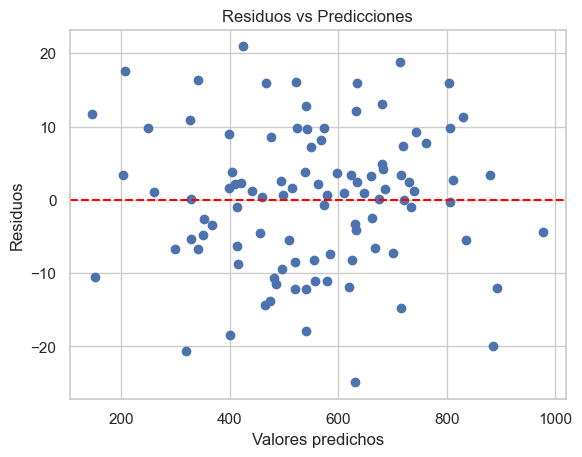

In [659]:
residuos = modelo.resid
predicciones = modelo.fittedvalues

plt.scatter(predicciones, residuos)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones")
plt.grid(True)
plt.show()

#### Interpretación

-  ✔️ los residuos están dispersos aleatoriamente alrededor de cero → buena señal de linealidad
- El modelo cumple con el supuesto de linealidad
- No hay evidencia visual de heterocedasticidad
- Los residuos parecen aleatorios y bien comportados

#

#### Test visual ✔️Si la línea lowess es horizontal → relación lineal

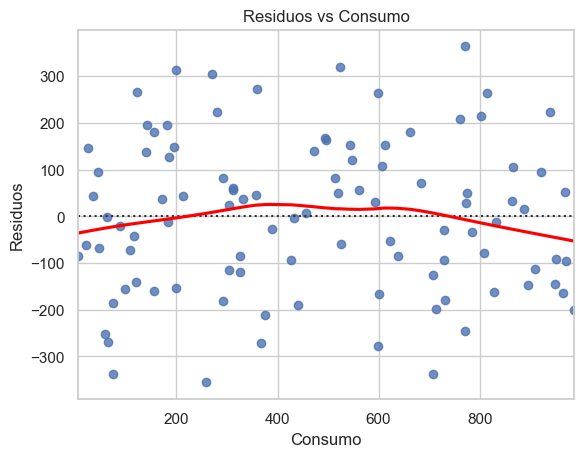

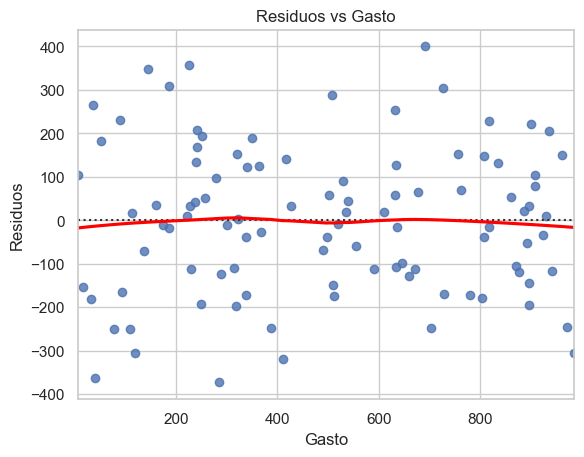

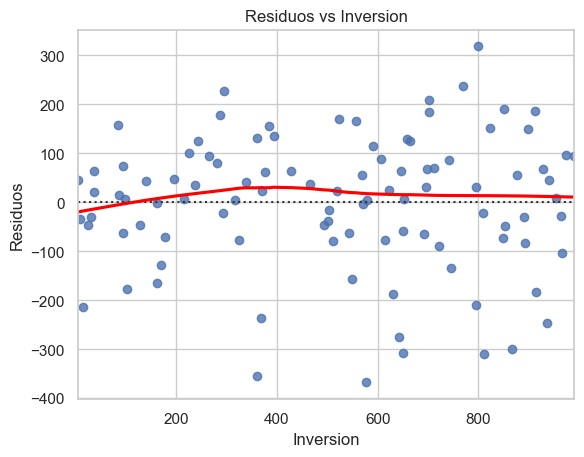

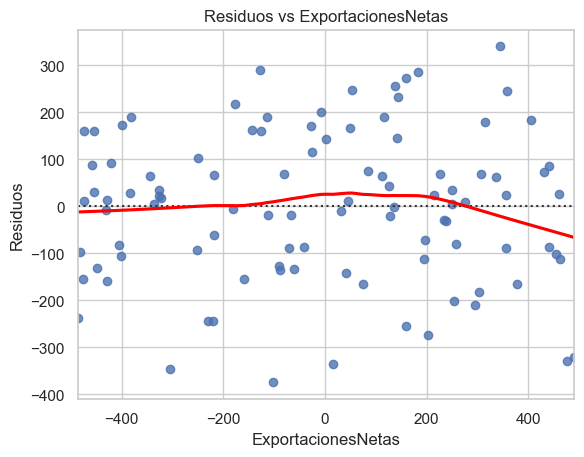

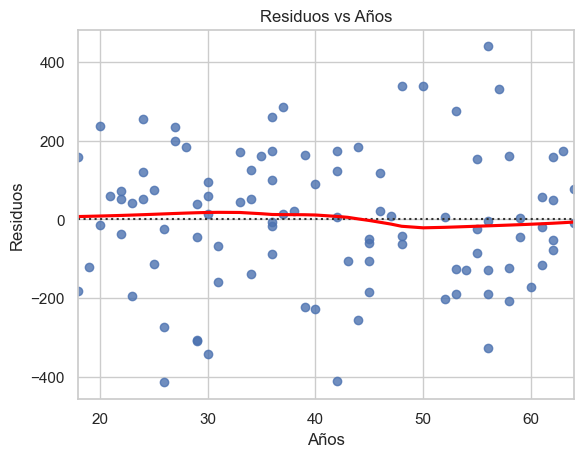

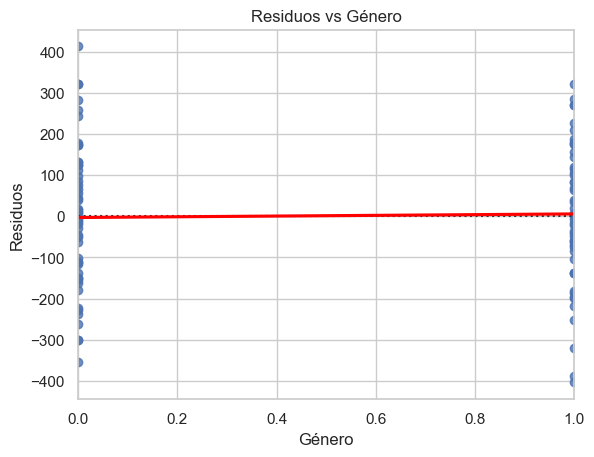

In [660]:
for col in X.columns[1:]:  # omitir el intercepto
    sns.residplot(x=df[col], y=df['Ingreso_M'], lowess=True, line_kws={'color': 'red'})
    plt.title(f"Residuos vs {col}")
    plt.xlabel(col)
    plt.ylabel("Residuos")
    plt.grid(True)
    plt.show()

#### Ramsey Reset test : evaluación de linealidad estructural del modelo .

In [661]:
from statsmodels.stats.diagnostic import linear_reset

reset_test = linear_reset(modelo, power=2, use_f=True)
print(f"Ramsey RESET test:\nF-statistic = {reset_test.fvalue:.4f}, p-valor = {reset_test.pvalue:.4f}")

Ramsey RESET test:
F-statistic = 0.2228, p-valor = 0.6380

#### Interpretación🧠 

- F-statistic es muy bajo, lo que indica que no hay evidencia fuerte de mejora al introducir no linealidades.
- 📌 p-valor = 0.6380, α = 0.05 → como p > α, no se rechaza la hipótesis nula.
- ✔️ El modelo cumple con el supuesto de linealidad funcional bajo el test RESET.
- Por lo tanto , no hay evidencia estadística suficiente para afirmar que faltan términos no lineales o que la especificación del modelo es incorrecto .

#

 #### Gráfica línea y boxplot 

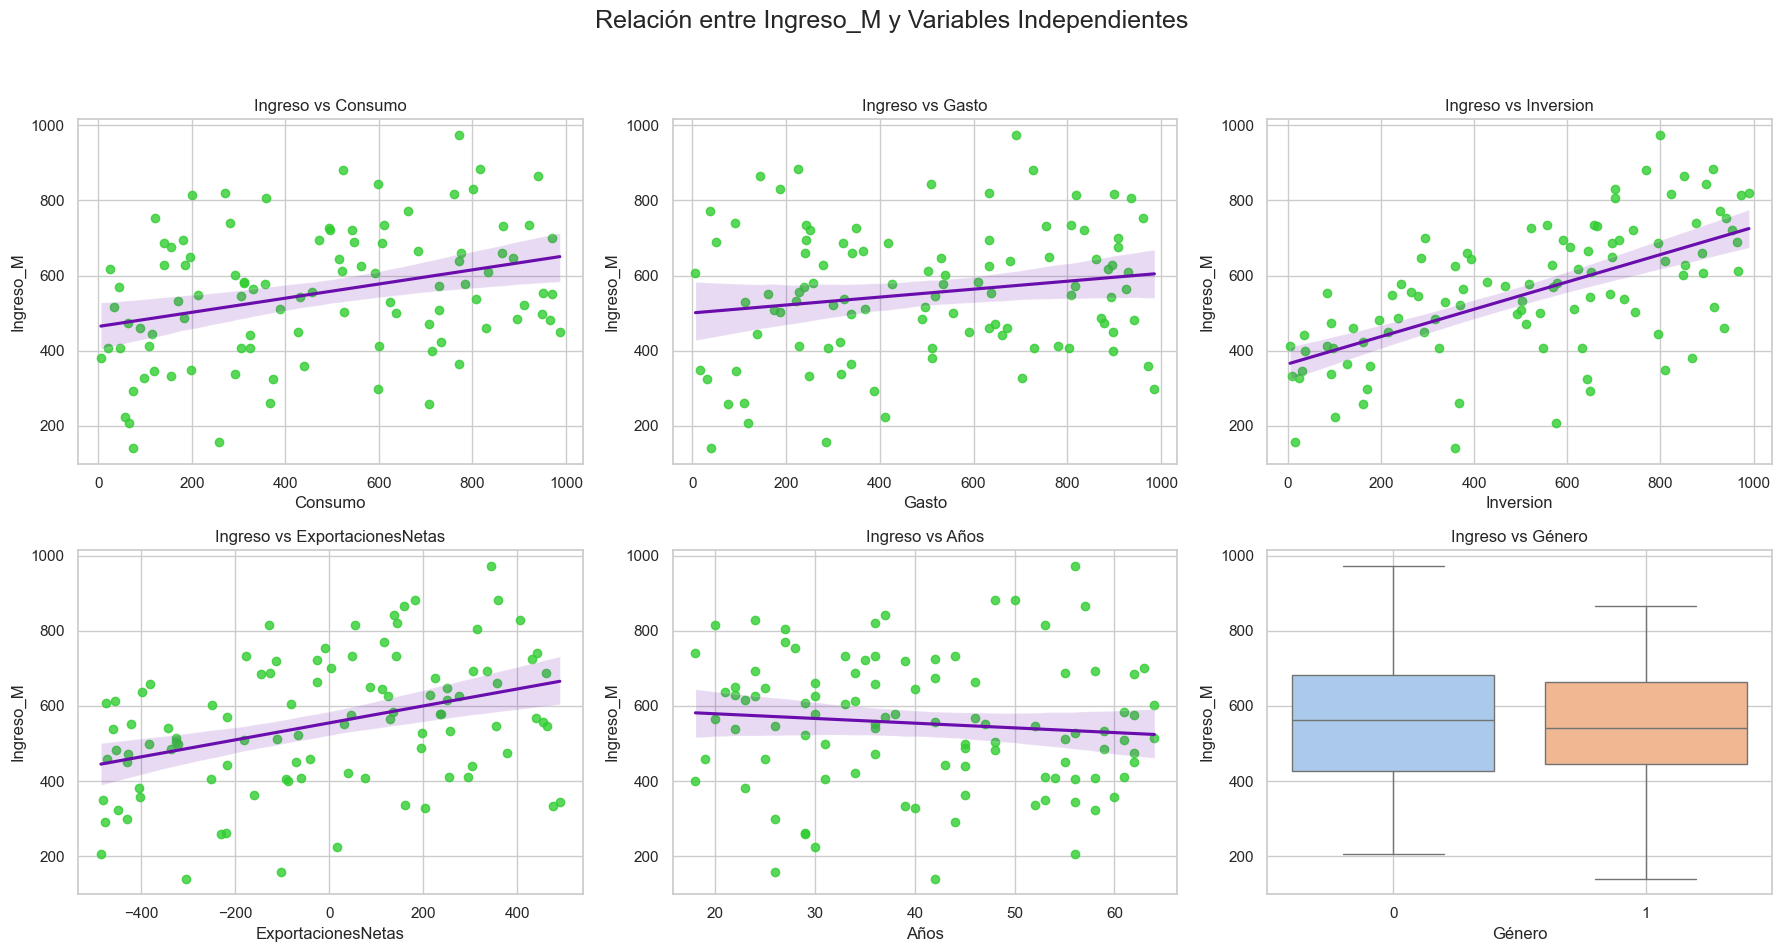

Por lo observado y test anterior, existe suficiente evidencia estadística de que existe linealidad en el modelo.

In [662]:
from rich import print 

variables = ['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Relación entre Ingreso_M y Variables Independientes', fontsize=18)
axes = axes.flatten()

for i, var in enumerate(variables):
    if df[var].nunique() <= 2:  # Dicotómica → boxplot
        sns.boxplot(x=df[var], y=df['Ingreso_M'], hue=df[var], palette='pastel', ax=axes[i], legend=False)
    else:  # Numérica → regplot
        sns.regplot(x=df[var], y=df['Ingreso_M'], scatter_kws={'color': '#32CD32'}, line_kws={'color': '#6A0DAD'}, ax=axes[i])
    
    axes[i].set_title(f'Ingreso vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Ingreso_M')
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("[bold]Por lo observado y test anterior, existe suficiente evidencia estadística de que existe linealidad en el modelo.[/bold]") # letra en negrita 

#

#### c) Analisis de homogenidad de varianza (homoscedasticidad)

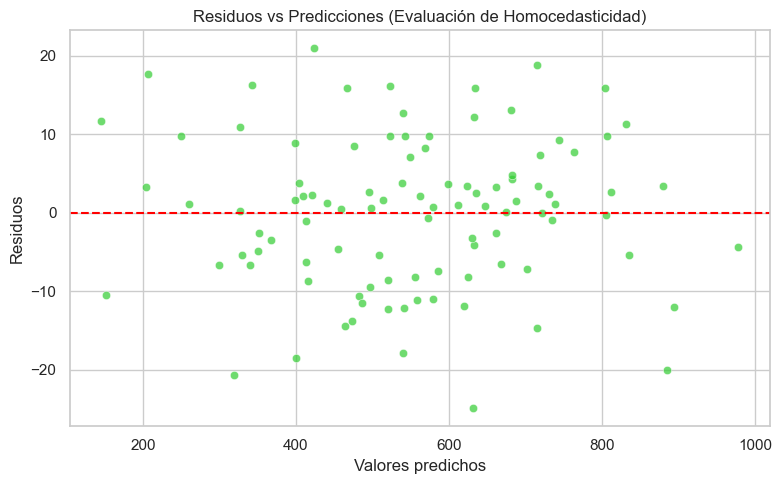

In [663]:
# Obtener residuos y valores predichos
residuos = modelo.resid
predicciones = modelo.fittedvalues

# Crear gráfico
plt.figure(figsize=(8, 5))
sns.scatterplot(x=predicciones, y=residuos, color='#32CD32', alpha=0.7)

# Línea horizontal en cero
plt.axhline(0, color='red', linestyle='--')

# Etiquetas
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones (Evaluación de Homocedasticidad)")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Diagnóstico Visual 

In [664]:
from rich.console import Console
from rich.panel import Panel
from rich import box

console = Console()

panel = Panel( "📊 Dispersión constante de residuos sin patrones visibles.\n✅ Indicación clara de homocedasticidad.", title="🧠 Diagnóstico Visual",
    border_style="cyan",box=box.ROUNDED)

console.print(panel)

╭───────────────────────────────────────────── 🧠 Diagnóstico Visual ─────────────────────────────────────────────╮
│ 📊 Dispersión constante de residuos sin patrones visibles.                                                      │
│ ✅ Indicación clara de homocedasticidad.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

#### Refuerzo diagnótico visual . se agrega una línea LOWESS para detectar tendencias en la dispersión .

 Gráfica respalda la suposición de linealidad y homocedasticidad 

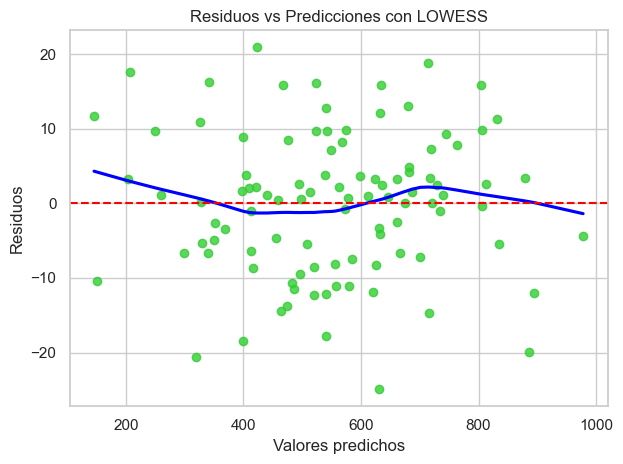

In [665]:
sns.regplot(x=predicciones, y=residuos, lowess=True, line_kws={'color': 'blue'}, scatter_kws={'color': '#32CD32'})
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones con LOWESS")
plt.grid(True)
plt.tight_layout()
print("[bold] Gráfica respalda la suposición de linealidad y homocedasticidad [/bold]")
plt.show()

##

#### Hipotesis para analizar homoscedastidad

- Hipótesis nula (H₀): Los residuos tienen varianza constante (homoscedasticidad)
- Hipótesis alternativa (H₁): Los residuos tienen varianza no constante (heterocedasticidad)

#### Prueba white

In [666]:
from statsmodels.stats.diagnostic import het_white

white_test = het_white(residuos, X)
white_stat = white_test[0]
white_pvalue = white_test[1]

print(f"🔍 White Test:\n  Estadístico = {white_stat:.4f}, p-valor = {white_pvalue:.4f}")


🔍 White Test:
  Estadístico = 40.2866, p-valor = 0.0366

#### 📉 Interpretación

- p-valor : 0.0366 , α = 0.05 → p-valor < α , se rechazas la hipótesis nula de homocedasticidad → hay indicios estadísticos de heterocedasticidad, aunque no se observan patrones visuales fuertes.
- existe una leve heterocedasticidad , no lo suficientemente fuerte como para alterar los resultados del modelo.

#

#### Modelo robusto (debido a lo anterior se aplica modelo robusto)

In [667]:
modelo_robusto = modelo.get_robustcov_results(cov_type='HC1')

#### 🔍 Diagnóstico visual del modelo robusto

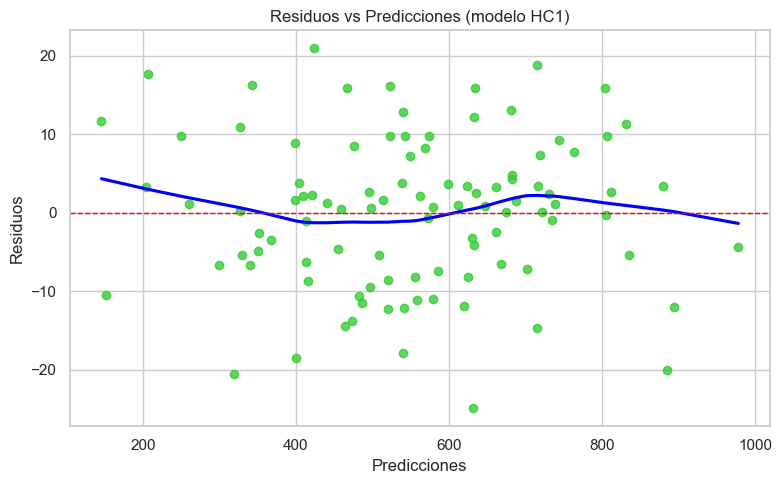

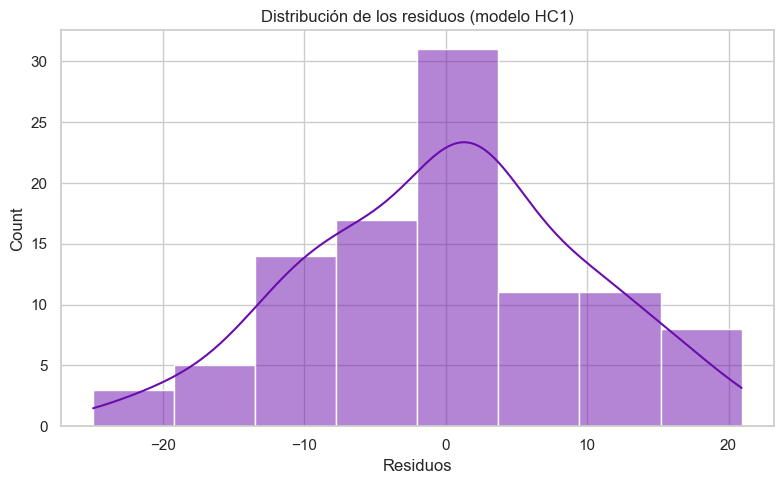

In [668]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo visual
sns.set_theme(style="whitegrid")

# Modelo robusto
modelo_robusto = modelo.get_robustcov_results(cov_type='HC1')
residuos = modelo_robusto.resid
predicciones = modelo_robusto.fittedvalues

# Gráfico de residuos vs predicciones 

plt.figure(figsize=(8, 5))
sns.regplot(x=predicciones, y=residuos, lowess=True, line_kws={'color': 'blue'}, scatter_kws={'color': '#32CD32'})
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuos vs Predicciones (modelo HC1)")
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histograma de residuos con KDE(linea suave)

plt.figure(figsize=(8, 5))
sns.histplot(residuos, kde=True, color='#6A0DAD')
plt.title("Distribución de los residuos (modelo HC1)")
plt.xlabel("Residuos")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 🧠 Conclusiones: 
- a) residuos están distribuidos sin patrón sistemático ,dispersión vertical de los puntos parece bastante constante a lo largo del eje X (predicciones) ,ahí una leve curvatura de linea azul pero no significativa luego existe homoscedasticidad .
- b) Forma simétrica y parecida a una campana gauss → ✔️ Indica que los residuos podrían aproximarse a una distribución normal (bueno para inferencias).
- c) El modelo HC1 es consistente frente a heterocedasticidad, pero en este caso parece que el supuesto clásico de varianza constante también se cumple, lo cual es excelente.

#### Contrateste de metricas de modelo original v/s modelo robusto .

- observación : modelo robusto es una medida de seguridad adicional, especialmente si el White Test detectan problemas. en este caso , sirve de apoyo . 

In [669]:
print("📊 Modelo clásico (OLS):")
print(modelo.summary())

print("\n🛡️ Modelo robusto (HC1):")
print(modelo_robusto.summary())

📊 Modelo clásico (OLS):

OLS Regression Results                            
==============================================================================
Dep. Variable:              Ingreso_M   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     5027.
Date:                Tue, 12 Aug 2025   Prob (F-statistic):          1.73e-114
Time:                        23:57:02   Log-Likelihood:                -367.73
No. Observations:                 100   AIC:                             749.5
Df Residuals:                      93   BIC:                             767.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.9001      5.239     -0.744      0.458     -14.303       6.503
Consumo                0.3011      0.003     87.001      0.000       0.294       0.308
Gasto                  0.2019      0.004     57.651      0.000       0.195       0.209
Inversion              0.4997      0.004    139.154      0.000       0.493       0.507
ExportacionesNetas     0.4042      0.004    111.831      0.000       0.397       0.411
Años                   1.2803      0.075     17.094      0.000       1.132       1.429
Género                14.3923      2.001      7.191      0.000      10.418      18.367
==============================================================================
Omnibus:                        0.643   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.725   Jarque-Bera (JB):                0.778
Skew:                          -0.128   Prob(JB):                        0.678
Kurtosis:                       2.652   Cond. No.                     4.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

🛡️ Modelo robusto (HC1):

OLS Regression Results                            
==============================================================================
Dep. Variable:              Ingreso_M   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     5116.
Date:                Tue, 12 Aug 2025   Prob (F-statistic):          7.62e-115
Time:                        23:57:02   Log-Likelihood:                -367.73
No. Observations:                 100   AIC:                             749.5
Df Residuals:                      93   BIC:                             767.7
Df Model:                           6                                         
Covariance Type:                  HC1                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.9001      5.874     -0.664      0.508     -15.564       7.764
Consumo                0.3011      0.004     74.885      0.000       0.293       0.309
Gasto                  0.2019      0.004     54.789      0.000       0.195       0.209
Inversion              0.4997      0.004    140.161      0.000       0.493       0.507
ExportacionesNetas     0.4042      0.004    105.641      0.000       0.397       0.412
Años                   1.2803      0.079     16.296      0.000       1.124       1.436
Género                14.3923      1.983      7.256      0.000      10.454      18.331
==============================================================================
Omnibus:                        0.643   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.725   Jarque-Bera (JB):                0.778
Skew:                          -0.128   Prob(JB):                        0.678
Kurtosis:                       2.652   Cond. No.                     4.78e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

######

#### 🧠 Comparación entre modelo clásico (OLS) y modelo robusto (HC1)
- ✅ Coeficientes estables: Todos los coeficientes se mantuvieron prácticamente iguales entre ambos modelos, lo que indica que la estructura del modelo es sólida.
- ✅ Significancia preservada: Los p-valores significativos se conservaron, lo que sugiere que las inferencias clave no se ven afectadas por la corrección robusta.
- 🔄 Cambios en errores estándar :
  - La constante aumentó de 5.239 → 5.874, lo que refleja mayor incertidumbre en su estimación.
  - El coeficiente de Género disminuyó de 2.001 → 1.1983, lo que indica que el error estándar clásico probablemente estaba sobreestimado.
- 📈 F-statistic: Aumentó ligeramente de 5027. → 5116. , lo que no altera la conclusión sobre la calidad del ajuste.


#### ✅ Conclusión
- El ajuste robusto no modificó las conclusiones del modelo, lo que indica que el modelo original ya era bien especificado y estadísticamente sólido. La única debilidad detectada fue la presencia de heterocedasticidad, que fue corregida adecuadamente mediante errores estándar robustos (HC1).


##

#### Prueba Goldfeld–Quandt

- Hipótesis nula (H₀): Los errores tienen varianza constante (homocedasticidad).
- Hipótesis alternativa (H₁): La varianza de los errores cambia sistemáticamente con una variable explicativa (heterocedasticidad).

In [670]:
import statsmodels.api as sm

# Variables explicativas (X) con constante
X = sm.add_constant(df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']])

# Variable dependiente (y)
y = df['Ingreso_M']

# Ajustar el modelo OLS
modelo = sm.OLS(y, X).fit()

# Prueba Goldfeld–Quandt
from statsmodels.stats.diagnostic import het_goldfeldquandt

gq_test = het_goldfeldquandt(modelo.resid, modelo.model.exog)

# Mostrar resultados
print("📊 Estadístico F:", gq_test[0])
print("📉 p-valor:", gq_test[1])
print("📌 ¿Rechazamos H₀ (homocedasticidad)?", "Sí" if gq_test[1] < 0.05 else "No")

📊 Estadístico F: 1.1929120301496852

📉 p-valor: 0.2827690324966636

📌 ¿Rechazamos H₀ (homocedasticidad)? No

#### Interpretación :
- El valor de F no es lo suficientemente grande como para rechazar la hipótesis nula de homocedasticidad.
- p-valor > 0.05, no se rechaza H₀.
- Por lo tanto , Modelo no presenta evidencia de heterocedasticidad significativa según esta prueba. Es decir, los errores parecen tener una varianza constante, lo cual es una buena señal para la validez de los estimadores OLS.

#### Conclusion final : 
- Visualmente, los residuos muestran una dispersión constante y sin patrón sistemático.
- Pruebas estadísticas como el White Test y Goldfeld-Quandt no detectaron heterocedasticidad significativa.
- El ajuste robusto (HC1) no modificó los coeficientes ni afectó la significancia, lo que sugiere que cualquier posible heterocedasticidad era leve y no compromete la interpretación.
- todo apunta a que el modelo está bien especificado y sus inferencias son fiables. 
- Por lo tanto, se concluye que el modelo cumple con el supuesto de homocedasticidad, y sus inferencias son estadísticamente confiables bajo estimación robusta.

####

### d) Observaciones son independientes

#### Durbin-Watson test , evalúa autocorrelación de los residuos en modelos lineales

📊 Interpretación del Durbin-Watson (estadístico de Durbin-Watson toma valores entre 0 y 4)
- Entre 0 y 1.5 👉 residuos del modelo tienden a estar correlacionados positivamente entre sí. Esto sugiere que los errores consecutivos se parecen — cuando uno es alto, el siguiente también tiende a serlo. No es ideal si estás buscando independencia entre observaciones.
- Entre 1.5 y 2.5 👉 No hay evidencia fuerte de autocorrelación. Es lo más cercano a residuos independientes, lo que cumple el supuesto de independencia del modelo clásico de regresión.
- Entre 2.5 y 4 👉 Indica autocorrelación negativa: los errores consecutivos tienden a moverse en direcciones opuestas (si uno sube, el otro baja). También rompe la independencia, aunque en sentido contrario al caso anterior.


#### Durbin-Watson test

In [671]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = np.round(durbin_watson(modelo.resid),2)
print("Estadístico de Durbin-Watson:", dw_stat)

Estadístico de Durbin-Watson: 2.15

#### Regla decisión 

In [672]:
dw_stat = np.round(durbin_watson(modelo.resid),2)
if 1.5 < dw_stat < 2.5:
   print(f"No hay evidencia de autocorrelación significativa ,en este caso Estadístico de Durbin-Watson es {dw_stat}: lo que indica que no hay autocorrelación en residuos del modelo.")    
else:
    print("Posible autocorrelación en los residuos.")  

No hay evidencia de autocorrelación significativa ,en este caso Estadístico de Durbin-Watson es 2.15: lo que indica
que no hay autocorrelación en residuos del modelo.

#### 📌 Conclusión 
- Modelo respeta el supuesto de independencia entre observaciones con bastante solidez , por otro lado  ausencia de autocorrelación en los residuos es un requisito clave para la eficiencia de los estimadores OLS y para evitar sesgos en la estimación de errores estándar.

###

####  Gráfico secuencial residuos

- Forma práctica y visual de detectar patrones de dependencia temporal o autocorrelación en los errores de un modelo.

╭───────────────────────────────────────────── 📊 Evaluación Visual ─────────────────────────────────────────────╮
│ Visualización de residuos secuenciales                                                                         │
│ Número de observaciones: 100                                                                                   │
│ Evaluando independencia (Ausencia de patrón definido: Es ideal. Apunta a que los residuos son independientes.) │
╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

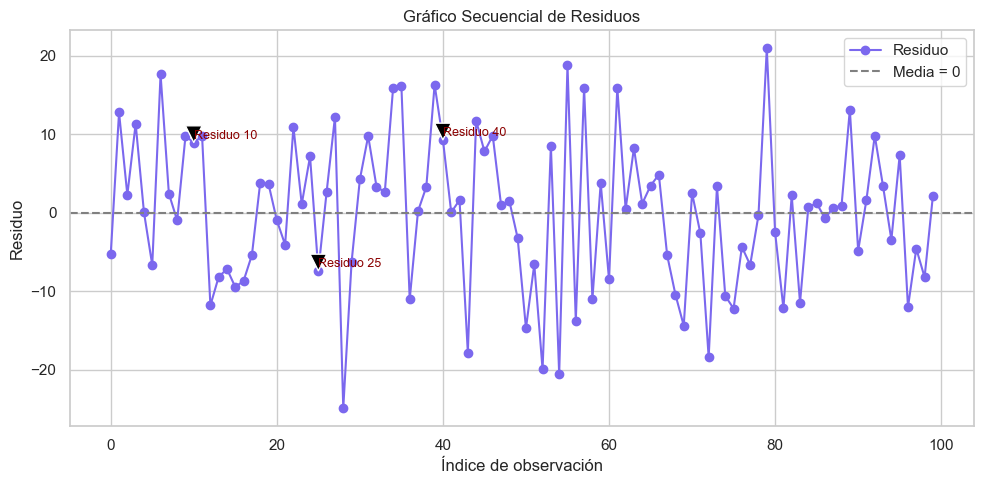

In [673]:
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.panel import Panel

# Imprimir contexto de observación 
residuos = modelo.resid 

print(Panel.fit(f"[bold cyan]Visualización de residuos secuenciales[/bold cyan]\n"
                f"Número de observaciones: {len(residuos)}\n"
                f"[green]Evaluando independencia (Ausencia de patrón definido: Es ideal. Apunta a que los residuos son independientes.)[/green]",
                title="📊 Evaluación Visual", border_style="blue"))

# Graficar residuos
plt.figure(figsize=(10, 5))
plt.plot(residuos, marker='o', linestyle='-', color='mediumslateblue', label='Residuo')
plt.axhline(0, color='gray', linestyle='--', label='Media = 0')

# Agregar anotaciones dinámicas
for i in [10, 25, 40]:
    plt.annotate(f'Residuo {i}', xy=(i, residuos[i]), xytext=(i, residuos[i] + 0.5), arrowprops=dict(facecolor='black', shrink=0.05),fontsize=9, color='darkred')

plt.title('Gráfico Secuencial de Residuos')
plt.xlabel('Índice de observación')
plt.ylabel('Residuo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### e) 🔍Medir Multicolinealidad 

- Forma más común es calcular el VIF (Variance Inflation Factor) para cada variable independiente. 
- VIF mide cuánto se inflan los errores estándar de los coeficientes debido a la correlación entre variables.

In [674]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from rich import print

#  X es matriz de variables independientes con constante
X = modelo.model.exog
vif_data = pd.DataFrame()
vif_data["Variable"] = modelo.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)

print("[bold cyan]📊 P-valores de los coeficientes del modelo:[/bold cyan]\n")
print(modelo.pvalues) # Obtener p-valores de los coeficientes

Variable        VIF
0               const  27.885937
1             Consumo   1.066128
2               Gasto   1.059837
3           Inversion   1.116899
4  ExportacionesNetas   1.131404
5                Años   1.056724
6              Género   1.017458

📊 P-valores de los coeficientes del modelo:

const                  4.584798e-01
Consumo                6.777354e-91
Gasto                  1.395132e-74
Inversion             1.023928e-109
ExportacionesNetas    6.117729e-101
Años                   1.880260e-30
Género                 1.596460e-10
dtype: float64

#### Interpretación :
- ⚙️Todos los VIF < 2, lo que indica que no hay correlación preocupante entre las variables independientes . El valor alto en const (27.89) no es un problema. este suele tener un VIF elevado porque está correlacionada con la suma de las variables, pero no afecta la interpretación del modelo.
- <span style="background-color: yellow;"> ✅ El modelo no presenta multicolinealidad significativa.
- 📊 Puedes confiar en la estabilidad de los coeficientes y en la validez de los p-valores.

#### Conclusión
- ✔️ No hay multicolinealidad significativa.
- 📈 Los coeficientes estimados son estables.
- 📉 Los p-valores son confiables para inferencia estadística.
- 🔍 Se puede proceder con análisis de significancia, interpretación de efectos, y predicción sin preocuparte por distorsiones por colinealidad.

###

#### 🧠 Conclusión Técnica
- 📈 El modelo cumple con todos los supuestos fundamentales de la regresión lineal clásica.
- 🔍 Los coeficientes pueden interpretarse con confianza, permitiendo realizar inferencias estadísticas y generar predicciones con alta validez.

### 

#### 2) 📈 Construcción modelo de regresión lineal múltiple y R²

In [675]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Definir variables
X = df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']]
y = df['Ingreso_M']

# Ajustar modelo
modelo = LinearRegression().fit(X, y)
intercepto = modelo.intercept_
coeficientes = modelo.coef_
r2 = r2_score(y, modelo.predict(X))

# Construcción de la expresión del modelo
variables = X.columns
componentes = [f"{intercepto:.2f}"] + [f"{'+' if c >= 0 else '−'} {abs(c):.2f}·{v}" for v, c in zip(variables, coeficientes)]
funcion = "Ingreso_M = " + " ".join(componentes)

# Salida estilizada y compacta
print(f"\n🧮 Modelo RLM : {funcion}")
print(f"🎯 R² del modelo: {r2:.4f}")

🧮 Modelo RLM : Ingreso_M = -3.90 + 0.30·Consumo + 0.20·Gasto + 0.50·Inversion + 0.40·ExportacionesNetas + 
1.28·Años + 14.39·Género

🎯 R² del modelo: 0.9969

### Modelo saturado y modelos con variable dicotómica aplicada

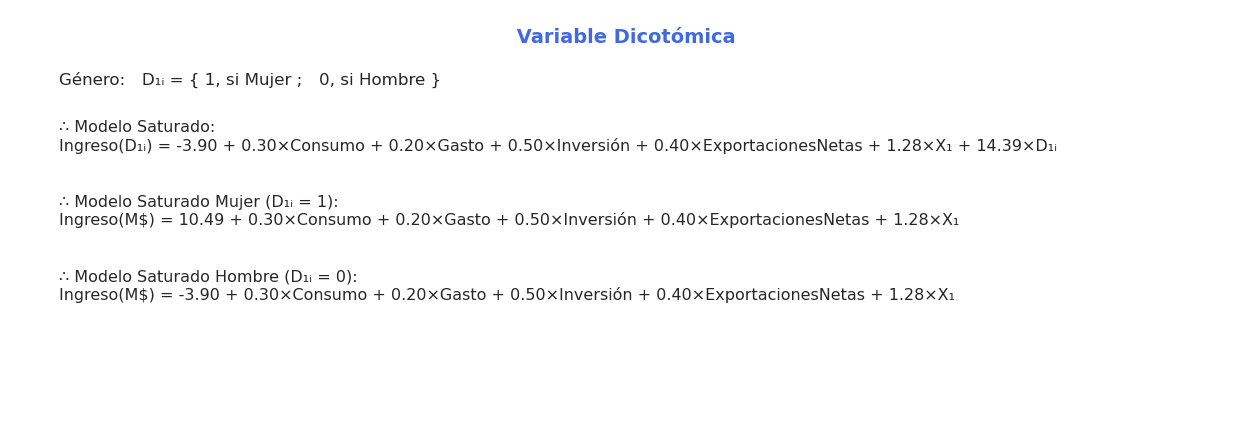

In [676]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"

# --- Configuración estética horizontal ---
fig, ax = plt.subplots(figsize=(13, 4.5))
ax.axis('off')

# --- Título subrayado elegante y definición dicotómica ---
titulo = " Variable Dicotómica "
dicotomica = "Género: D₁ᵢ = { 1, si Mujer ; 0, si Hombre }"

# --- Modelo Saturado (función general con D₁ᵢ) ---
modelo_saturado = (
    "∴ Modelo Saturado:\n"
    "Ingreso(D₁ᵢ) = -3.90 + 0.30×Consumo + 0.20×Gasto + 0.50×Inversión "
    "+ 0.40×ExportacionesNetas + 1.28×X₁ + 14.39×D₁ᵢ"
)

# --- Modelos particulares con constantes ya operadas ---
modelo_saturado_mujer = (
    "∴ Modelo Saturado Mujer (D₁ᵢ = 1):\n"
    "Ingreso(M$) = 10.49 + 0.30×Consumo + 0.20×Gasto + 0.50×Inversión "
    "+ 0.40×ExportacionesNetas + 1.28×X₁"
)

modelo_saturado_hombre = (
    "∴ Modelo Saturado Hombre (D₁ᵢ = 0):\n"
    "Ingreso(M$) = -3.90 + 0.30×Consumo + 0.20×Gasto + 0.50×Inversión "
    "+ 0.40×ExportacionesNetas + 1.28×X₁"
)

# --- Impresión visual clara ---
ax.text(0.5, 0.92, titulo, fontsize=14, color='royalblue', weight='bold', ha='center')
ax.text(0.04, 0.82, dicotomica, fontsize=12)

ax.text(0.04, 0.66, modelo_saturado, fontsize=11.5)
ax.text(0.04, 0.48, modelo_saturado_mujer, fontsize=11.5)
ax.text(0.04, 0.30, modelo_saturado_hombre, fontsize=11.5)

plt.tight_layout()
plt.show()

#### 3) Estimación puntual de los parámetros

In [677]:
import statsmodels.api as sm

X = df[["Consumo","Gasto", "Inversion", "ExportacionesNetas","Años","Género"]]  # predictores
X = sm.add_constant(X)  # añade β₀
y = df["Ingreso_M"]        # variable dependiente

modelo = sm.OLS(y, X).fit()

print(modelo.params) # Estimaciones puntuales

const                 -3.900104
Consumo                0.301084
Gasto                  0.201893
Inversion              0.499725
ExportacionesNetas     0.404169
Años                   1.280342
Género                14.392267
dtype: float64

#### Interpretación de coeficientes del modelo 

In [678]:
from rich.console import Console
from rich.table import Table
from rich import box

# Crear consola
console = Console()

# Crear tabla estilizada
table = Table(title="📊 Interpretación de Coeficientes del Modelo de Ingreso", box=box.SIMPLE_HEAVY)

# Definir columnas
table.add_column("Variable", style="bold cyan", justify="left")
table.add_column("Coeficiente", style="bold magenta", justify="center")
table.add_column("Interpretación", style="bold grey37", justify="left")

# Agregar filas
table.add_row("Intercepto", "−3.90", "Ingreso esperado cuando todas las variables son 0. Punto de partida teórico.")
table.add_row("Consumo", "+0.30", "Cada unidad adicional en consumo aumenta el ingreso en 0.30 millones de pesos.")
table.add_row("Gasto", "+0.20", "Cada unidad adicional en gasto incrementa el ingreso en 0.20 millones.")
table.add_row("Inversión", "+0.50", "Aporta positivamente: +0.50 millones por unidad adicional.")
table.add_row("Exportaciones Netas", "+0.40", "Contribuye con +0.40 millones por cada unidad adicional.")
table.add_row("Años (Edad)", "+1.28", "Por cada año adicional, el ingreso aumenta en 1.28 millones.")
table.add_row("Género (D₁ᵢ)", "+14.39", "Si D₁ᵢ = 1 (Mujer), el ingreso es 14.39 millones mayor que si D₁ᵢ = 0 (Hombre), ceteris paribus.")

# Mostrar tabla
console.print(table)

                              📊 Interpretación de Coeficientes del Modelo de Ingreso                              
                                                                                                                   
  Variable              Coeficiente   Interpretación                                                               
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Intercepto               −3.90      Ingreso esperado cuando todas las variables son 0. Punto de partida          
                                      teórico.                                                                     
  Consumo                  +0.30      Cada unidad adicional en consumo aumenta el ingreso en 0.30 millones de      
                                      pesos.                                                                       
  Gasto                    +0.20      Cada unidad adicional en gasto incrementa el ingreso en 0.20 millones.       
  Inversión                +0.50      Aporta positivamente: +0.50 millones por unidad adicional.                   
  Exportaciones Netas      +0.40      Contribuye con +0.40 millones por cada unidad adicional.                     
  Años (Edad)              +1.28      Por cada año adicional, el ingreso aumenta en 1.28 millones.                 
  Género (D₁ᵢ)            +14.39      Si D₁ᵢ = 1 (Mujer), el ingreso es 14.39 millones mayor que si D₁ᵢ = 0        
                                      (Hombre), ceteris paribus.                                                  

#### Visualización comparación entre modelos (OLS,RLM)

OLS        RLM  Diferencia
const               -3.900104  -3.810930    0.089174
Consumo              0.301084   0.301970    0.000886
Gasto                0.201893   0.201473   -0.000420
Inversion            0.499725   0.500169    0.000444
ExportacionesNetas   0.404169   0.404148   -0.000021
Años                 1.280342   1.272887   -0.007455
Género              14.392267  14.161234   -0.231032

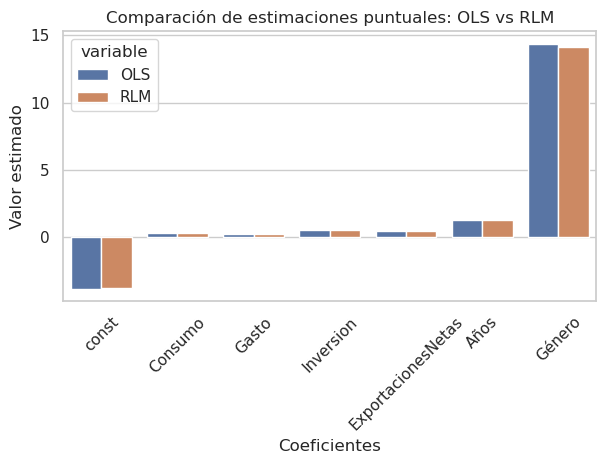

In [679]:
#🧪 Ajustar ambos modelo

import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes tus datos X (con constante) e y
modelo_ols = sm.OLS(y, X).fit()
modelo_rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()

#Crear un DataFrame comparativo

comparacion = pd.DataFrame({
    'OLS': modelo_ols.params,
    'RLM': modelo_rlm.params,
    'Diferencia': modelo_rlm.params - modelo_ols.params
})
print(comparacion)

# gráfica 

comparacion_melt = comparacion[['OLS', 'RLM']].reset_index().melt(id_vars='index')
sns.barplot(data=comparacion_melt, x='index', y='value', hue='variable')
plt.title('Comparación de estimaciones puntuales: OLS vs RLM')
plt.xlabel('Coeficientes')
plt.ylabel('Valor estimado')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Influencia de variable dicotómica Género en el modelo

In [680]:
from rich.console import Console
from rich.panel import Panel

console = Console()

texto = """
📌 VARIABLE: Género

Todo indica que Género influye en el modelo de ingreso, según la interpretación de coeficientes y la visualización comparativa.

El coeficiente estimado es alto y consistente entre modelos OLS y robustos (HC1), lo que sugiere un efecto significativo y estable.

Esto implica que el Género tiene un impacto relevante en el ingreso, manteniendo constantes las demás variables.
"""

console.print(Panel.fit(texto, title="Influencia de Género en el Modelo", border_style="green"))

╭─────────────────────────────────────── Influencia de Género en el Modelo ───────────────────────────────────────╮
│                                                                                                                 │
│ 📌 VARIABLE: Género                                                                                             │
│                                                                                                                 │
│ Todo indica que Género influye en el modelo de ingreso, según la interpretación de coeficientes y la            │
│ visualización comparativa.                                                                                      │
│                                                                                                                 │
│ El coeficiente estimado es alto y consistente entre modelos OLS y robustos (HC1), lo que sugiere un efecto      │
│ significativo y estable.                                                                                        │
│                                                                                                                 │
│ Esto implica que el Género tiene un impacto relevante en el ingreso, manteniendo constantes las demás           │
│ variables.                                                                                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

###

#### Estimación del Ingreso promedio por género mediante regresión lineal múltiple

In [681]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from rich.console import Console
from rich.table import Table
from rich.panel import Panel

# 🧼 Paso 1: limpieza y conversión
df = df.copy()

# Re-codificar Género si está en texto
if df["Género"].dtype == "object":
    df["Género"] = df["Género"].map({"Masculino": 0, "Femenino": 1})

# Convertir todas las columnas predictoras a float
predictoras = ["Consumo", "Gasto", "Inversion", "ExportacionesNetas", "Años", "Género"]
df[predictoras] = df[predictoras].astype(float)

# Eliminar filas con NaN en predictoras o target
df = df.dropna(subset=predictoras + ["Ingreso_M"])

# 📊 Paso 2: preparar X e y
X = df[predictoras]
X = sm.add_constant(X)
y = df["Ingreso_M"]

# ⚙️ Paso 3: ajustar modelo
modelo = sm.OLS(y, X).fit()

# 🧮 Paso 4: estimar ingreso promedio por género
promedios = df[["Consumo", "Gasto", "Inversion", "ExportacionesNetas", "Años"]].mean()
X_mujer  = [1] + list(promedios) + [1]
X_hombre = [1] + list(promedios) + [0]

params = modelo.params
ingreso_mujer  = sum([a * b for a, b in zip(X_mujer, params)])
ingreso_hombre = sum([a * b for a, b in zip(X_hombre, params)])
diferencia     = ingreso_mujer - ingreso_hombre
porcentaje     = (diferencia / ingreso_hombre) * 100

# 🎨 Paso 5: mostrar resultados con Rich
console = Console()
tabla = Table(title="Ingreso Estimado Promedio y Diferencia Marginal por Género", show_lines=True)

tabla.add_column("Género", justify="center", style="bold")
tabla.add_column("Ingreso Estimado", justify="right", style="cyan")
tabla.add_column("Diferencia vs Hombre", justify="right", style="magenta")
tabla.add_column("Porcentaje Relativo", justify="right", style="green")

tabla.add_row("Mujer",  f"${ingreso_mujer:,.2f}", f"${diferencia:,.2f}", f"{porcentaje:.2f}%")
tabla.add_row("Hombre", f"${ingreso_hombre:,.2f}", "$0.00", "0.00%")

console.print(tabla)

# 🧠 Panel interpretativo adicional (opcional)
panel = Panel.fit(
    f"[bold]El género tiene un efecto marginal estimado de[/bold] ${diferencia:,.2f}, "
    f"equivalente a un {porcentaje:.2f}% de diferencia relativa en ingreso estimado.",
    title="Impacto estimado del Género en el Ingreso",
    border_style="magenta",
    padding=(1, 4)
)
console.print(panel)

        Ingreso Estimado Promedio y Diferencia Marginal por Género        
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Género ┃ Ingreso Estimado ┃ Diferencia vs Hombre ┃ Porcentaje Relativo ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ Mujer  │          $560.17 │               $14.39 │               2.64% │
├────────┼──────────────────┼──────────────────────┼─────────────────────┤
│ Hombre │          $545.77 │                $0.00 │               0.00% │
└────────┴──────────────────┴──────────────────────┴─────────────────────┘

╭─────────────────────────────────── Impacto estimado del Género en el Ingreso ───────────────────────────────────╮
│                                                                                                                 │
│    El género tiene un efecto marginal estimado de $14.39, equivalente a un 2.64% de diferencia relativa en      │
│    ingreso estimado.                                                                                            │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

#### 4) Intervalos de confianza

##### Observación , expresión matemática escrita en https://www.mathcha.io/

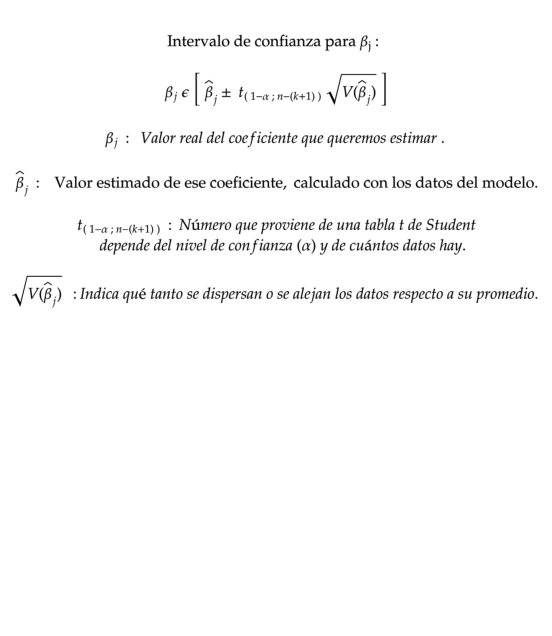

In [682]:
import matplotlib.image as mpimg

# Cargar imagen
img = mpimg.imread(r"C:\Users\ASUS\Desktop\Proyecto modelado de prediccion Scikit-learn\Intervalo confianza coeficientes.png")

# Ajustar tamaño de figura (ancho, alto) en unidades : pulgadas
plt.figure(figsize=(14, 8))  # Puedes modificar los valores a lo que necesites

plt.imshow(img)
plt.axis('off')
plt.show()

In [683]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ajustar el modelo
modelo = ols(
    'Q("Ingreso_M") ~ Q("Consumo") + Q("Gasto") + Q("Inversion") + Q("ExportacionesNetas") + Q("Años") + Q("Género")',data=df).fit()

# Mostrar intervalos de confianza con 4 decimales
print("\n📏 Intervalos de confianza (95%):\n")
print(modelo.conf_int().round(4))

📏 Intervalos de confianza (95%):

0        1
Intercept               -14.3035   6.5033
Q("Consumo")              0.2942   0.3080
Q("Gasto")                0.1949   0.2088
Q("Inversion")            0.4926   0.5069
Q("ExportacionesNetas")   0.3970   0.4113
Q("Años")                 1.1316   1.4291
Q("Género")              10.4179  18.3667

#### Interpretación 

- Hay poca dispersión alrededor del coeficiente estimado.
- La incertidumbre estadística asociada es baja.
- Buena calidad de los datos.
- Multicolinealidad controlada, porque altos niveles pueden inflar los errores estándar.
- Modelo correctamente especificado .

#### Gráfica campana de gauss por cada coeficiente

 Intervalo de confianza al 95%

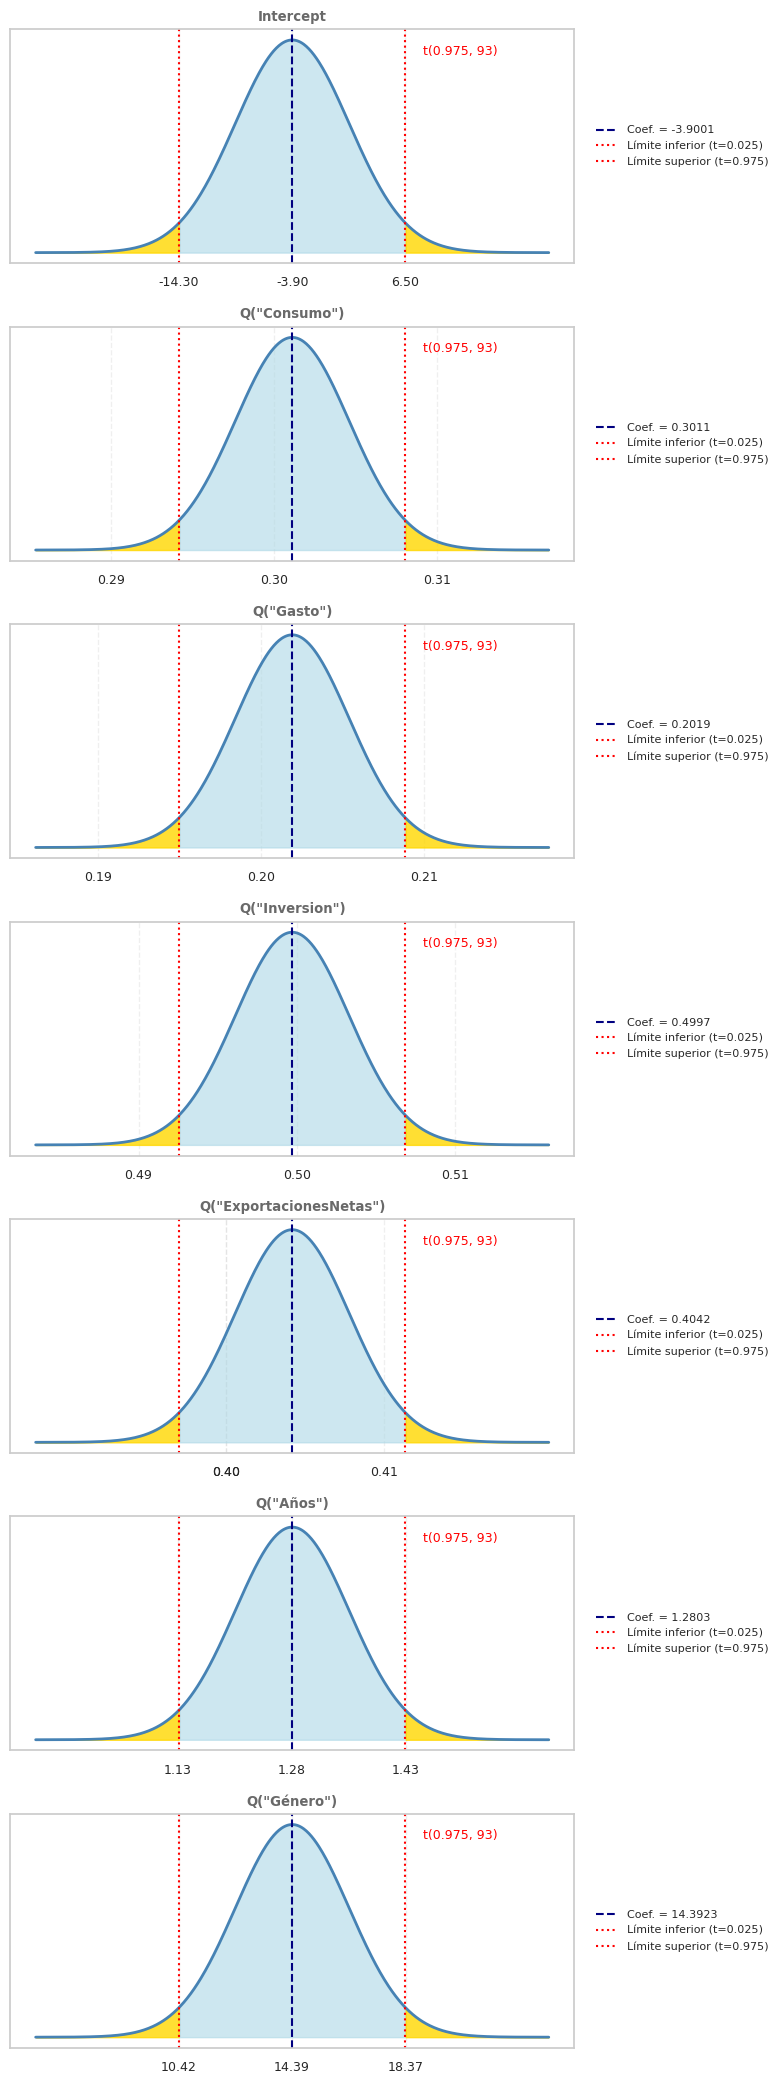

In [684]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
from rich import print
from rich.align import Align

# --- Ajustar el modelo ---
modelo = ols(
    'Q("Ingreso_M") ~ Q("Consumo") + Q("Gasto") + Q("Inversion") + Q("ExportacionesNetas") + Q("Años") + Q("Género")',
    data=df
).fit()

# --- Extraer coeficientes y errores estándar ---
tabla = modelo.summary2().tables[1][["Coef.", "Std.Err."]].round(4)

# --- Valor t crítico para 93 grados de libertad ---
valor_t = 1.986  # t_(0.975, 93)

# --- Visualización por parámetro ---
fig, axs = plt.subplots(len(tabla), 1, figsize=(8, len(tabla)*3))
titulo = "[bold black] Intervalo de confianza al 95%[/bold black]"

print(Align.center(titulo))

for i, (param, row) in enumerate(tabla.iterrows()):
    media = row["Coef."]
    std = row["Std.Err."]
    
    # Curva de densidad
    x = np.linspace(media - 4.5*std, media + 4.5*std, 600)
    y = norm.pdf(x, loc=media, scale=std)

    # Intervalos de confianza
    ci_low = media - valor_t * std
    ci_high = media + valor_t * std

    ax = axs[i]
    ax.plot(x, y, color="steelblue", lw=2)

    # 🔵 Zona aceptada
    ax.fill_between(x, y, where=(x >= ci_low) & (x <= ci_high), color="lightblue", alpha=0.6)

    # 🟡 Zonas críticas
    ax.fill_between(x, y, where=(x < ci_low), color="gold", alpha=0.8)
    ax.fill_between(x, y, where=(x > ci_high), color="gold", alpha=0.8)

    # Líneas verticales
    ax.axvline(media, color="navy", linestyle='--', lw=1.5, label=f"Coef. = {media:.4f}")
    ax.axvline(ci_low, color="red", linestyle=':', lw=1.5, label="Límite inferior (t=0.025)")
    ax.axvline(ci_high, color="red", linestyle=':', lw=1.5, label="Límite superior (t=0.975)")

    # 🏷 Etiqueta t(0.975, 93) levemente desplazada
    desplazamiento = std * 0.3
    ax.text(ci_high + desplazamiento, max(y)*0.93, "t(0.975, 93)", color="red", fontsize=9, ha="left")

    # Eje X con solo los valores clave
    ax.set_xticks([round(ci_low, 2), round(media, 2), round(ci_high, 2)])
    ax.set_xticklabels([
        f"{ci_low:.2f}", 
        f"{media:.2f}", 
        f"{ci_high:.2f}"
    ], fontsize=9)

    #ax.set_title(f"{param}", fontsize=12, weight='bold')
    ax.set_title(f"{param}", fontsize=9.5, weight='bold', color='dimgray')
    ax.set_yticks([])
    ax.grid(True, linestyle='--', alpha=0.3)

    # 📄 Leyenda fuera del gráfico (a la derecha)
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=8,
        frameon=False
    )

plt.tight_layout()
plt.show()

###

#### Estimación del ingreso promedio por género con intervalo de confianza (95%) para la media de Ingreso_M

In [685]:
from scipy.stats import t

# Número de observaciones y variables
n = len(df)
k = len(predictoras)
gl = n - k - 1
alpha = 0.05
t_critico = t.ppf(1 - alpha/2, df=gl)

# Matriz de diseño para cada género
X_mujer_np  = np.array(X_mujer).reshape(1, -1)
X_hombre_np = np.array(X_hombre).reshape(1, -1)

# Error estándar de la predicción
SE_mujer  = np.sqrt(X_mujer_np @ modelo.cov_params() @ X_mujer_np.T)[0][0]
SE_hombre = np.sqrt(X_hombre_np @ modelo.cov_params() @ X_hombre_np.T)[0][0]

# Intervalos de confianza
IC_mujer  = (ingreso_mujer - t_critico * SE_mujer, ingreso_mujer + t_critico * SE_mujer)
IC_hombre = (ingreso_hombre - t_critico * SE_hombre, ingreso_hombre + t_critico * SE_hombre)

In [686]:
from rich.console import Console
from rich.table import Table

# 🎨 Crear tabla Rich 
tabla = Table(title="Ingreso Estimado Promedio por Género", show_lines=True)
tabla.add_column("Género", justify="center", style="bold")
tabla.add_column("Ingreso Estimado", justify="right", style="cyan")
tabla.add_column("IC 95%", justify="center", style="green")

# 🧾 Agregar filas con intervalos
tabla.add_row(
    "Mujer",
    f"${ingreso_mujer:,.2f}",
    f"[${IC_mujer[0]:,.2f}, ${IC_mujer[1]:,.2f}]"
)
tabla.add_row(
    "Hombre",
    f"${ingreso_hombre:,.2f}",
    f"[${IC_hombre[0]:,.2f}, ${IC_hombre[1]:,.2f}]"
)

# 🖥️ Mostrar en consola
console = Console()
console.print(tabla)

       Ingreso Estimado Promedio por Género       
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Género ┃ Ingreso Estimado ┃       IC 95%       ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Mujer  │          $560.17 │ [$557.37, $562.96] │
├────────┼──────────────────┼────────────────────┤
│ Hombre │          $545.77 │ [$542.98, $548.57] │
└────────┴──────────────────┴────────────────────┘

####

#### Gráfica estimación del ingreso promedio por género con intervalo de confianza (95%) para la media de Ingreso_M

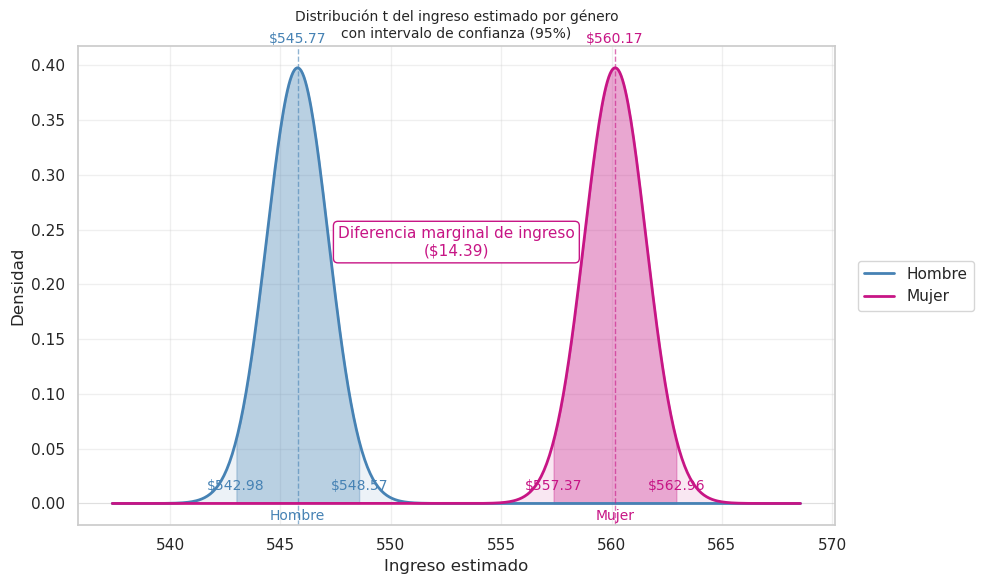

In [687]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import matplotlib

matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# 🎨 Colores por grupo
color_hombre = "steelblue"
color_mujer  = "mediumvioletred"

# 🎯 Eje X corregido con margen extendido
margen = max(SE_mujer, SE_hombre) * t_critico * 3
x_min = min(ingreso_hombre, ingreso_mujer) - margen
x_max = max(ingreso_hombre, ingreso_mujer) + margen
x = np.linspace(x_min, x_max, 500)

# 📈 Densidades t
y_hombre = t.pdf((x - ingreso_hombre) / SE_hombre, df=gl)
y_mujer  = t.pdf((x - ingreso_mujer) / SE_mujer, df=gl)

# 📊 Figura
plt.figure(figsize=(10, 6))
plt.axhline(0, color="gray", linewidth=0.5, alpha=0.2)

# 🔹 Hombre
plt.fill_between(x, y_hombre, color=color_hombre, alpha=0.1)
plt.fill_between(x, y_hombre, where=(x >= IC_hombre[0]) & (x <= IC_hombre[1]), color=color_hombre, alpha=0.3)
plt.plot(x, y_hombre, label="Hombre", color=color_hombre, linewidth=2)
plt.axvline(ingreso_hombre, color=color_hombre, linestyle="--", linewidth=1, alpha=0.6)

# 🔸 Mujer
plt.fill_between(x, y_mujer, color=color_mujer, alpha=0.1)
plt.fill_between(x, y_mujer, where=(x >= IC_mujer[0]) & (x <= IC_mujer[1]), color=color_mujer, alpha=0.3)
plt.plot(x, y_mujer, label="Mujer", color=color_mujer, linewidth=2)
plt.axvline(ingreso_mujer, color=color_mujer, linestyle="--", linewidth=1, alpha=0.6)

# 🏷️ Función de anotación
def anotar(valor, y, texto, color):
    plt.text(valor, y, texto, color=color, ha="center", va="bottom", fontsize=10)

# 📍 Anotaciones Hombre
anotar(IC_hombre[0], 0.01, f"${IC_hombre[0]:,.2f}", color_hombre)
anotar(IC_hombre[1], 0.01, f"${IC_hombre[1]:,.2f}", color_hombre)
anotar(ingreso_hombre, max(y_hombre)*1.05, f"${ingreso_hombre:,.2f}", color_hombre)

# 📍 Anotaciones Mujer
anotar(IC_mujer[0], 0.01, f"${IC_mujer[0]:,.2f}", color_mujer)
anotar(IC_mujer[1], 0.01, f"${IC_mujer[1]:,.2f}", color_mujer)
anotar(ingreso_mujer, max(y_mujer)*1.05, f"${ingreso_mujer:,.2f}", color_mujer)

# 💬 Texto narrativo
diferencia = ingreso_mujer - ingreso_hombre
texto_dif = f"Diferencia marginal de ingreso\n(${abs(diferencia):,.2f})"
x_texto = (ingreso_mujer + ingreso_hombre) / 2
y_texto = max(max(y_mujer), max(y_hombre)) * 0.6
color_dif = color_mujer if diferencia > 0 else color_hombre

plt.text(x_texto, y_texto, texto_dif, fontsize=11, color=color_dif, ha="center", va="center",
         bbox=dict(facecolor="white", edgecolor=color_dif, boxstyle="round,pad=0.3"))

# 🧾 Etiquetas de grupo sobre eje X
plt.text(ingreso_hombre, -0.005, "Hombre", color=color_hombre, ha="center", va="top", fontsize=10)
plt.text(ingreso_mujer, -0.005, "Mujer", color=color_mujer, ha="center", va="top", fontsize=10)

# 📋 Estilo final
plt.title("Distribución t del ingreso estimado por género\ncon intervalo de confianza (95%)", fontsize=10)
plt.xlabel("Ingreso estimado", fontsize=12)
plt.ylabel("Densidad", fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##### 

#### 5) Contrastes de hipotesis 

#### a) Prueba de hipotesis sobre todos los parámetros del modelo , Test F y p-valor 

In [688]:
# Hipótesis del test F global
print("\n🧪 Hipótesis del test F global:")
print("H₀: Modelo no adecuado ⇒ Todos los coeficientes son cero (β₁ = β₂ = ... = βₖ = 0)")
print("Hₐ: Modelo adecuado ⇒ Al menos un coeficiente es distinto de cero (∃ βⱼ ≠ 0)")

🧪 Hipótesis del test F global:

H₀: Modelo no adecuado ⇒ Todos los coeficientes son cero (β₁ = β₂ = ... = βₖ = 0)

Hₐ: Modelo adecuado ⇒ Al menos un coeficiente es distinto de cero (∃ βⱼ ≠ 0)

In [689]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy.stats import f
from rich.console import Console
from rich.table import Table
from rich import box

console = Console()

# Datos y regresión 
X = sm.add_constant(df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']])
y = df['Ingreso_M']
modelo = sm.OLS(y, X).fit()

# Sumas de cuadrados y grados de libertad
SCT = np.sum((y - y.mean())**2)
SCE = np.sum(modelo.resid**2)
SCR = SCT - SCE
n, k = X.shape[0], X.shape[1] - 1
df_modelo, df_error = k, n - (k + 1)

# Estadístico F, p-valor, F crítico 
F_calc = (SCR / df_modelo) / (SCE / df_error)
p_value = 1 - f.cdf(F_calc, df_modelo, df_error)
F_crit = f.ppf(1 - 0.05, df_modelo, df_error)
alfa = 0.05

# Diccionario nombres 
nombres = {
    'const': 'Intercepto', 'Consumo': 'Consumo', 'Gasto': 'Gasto',
    'Inversion': 'Inversión', 'ExportacionesNetas': 'Exportaciones Netas',
    'Años': 'Años', 'Género': 'Género (1=Mujer, 0=Hombre)'
}

# Tabla coeficientes individuales

tabla = modelo.summary2().tables[1][["Coef.", "Std.Err.", "t", "P>|t|"]]
tabla["Significancia (α=0.05)"] = tabla["P>|t|"].apply(lambda p: "✅ Sí" if p < 0.05 else "❌ No")
tabla.rename(index=nombres, inplace=True)


# Tabla 1: Fórmulas y componentes 

tabla_formulas = Table(title="🧮 Fórmulas y Componentes", box=box.SIMPLE)
tabla_formulas.add_column("Concepto", style="bold green")
tabla_formulas.add_column("Expresión", style="white")
tabla_formulas.add_row("Fórmula F", "(SCR / k) / (SCE / (n - k - 1))")
tabla_formulas.add_row("SCR", f"{SCR:.4f}")
tabla_formulas.add_row("SCE", f"{SCE:.4f}")
tabla_formulas.add_row("SCT", f"{SCT:.4f}")
tabla_formulas.add_row("Grados de libertad modelo", str(df_modelo))
tabla_formulas.add_row("Grados de libertad error", str(df_error))
console.print(tabla_formulas)

# Tabla 2: Resultados globales

tabla_resultados = Table(title="📊 Resultados Globales del Test F", box=box.SIMPLE)
tabla_resultados.add_column("Elemento", style="bold cyan")
tabla_resultados.add_column("Valor", style="white")
tabla_resultados.add_row("n ", str(n))
tabla_resultados.add_row("k ", str(k))
tabla_resultados.add_row("F calculado", f"{F_calc:.4f}")
tabla_resultados.add_row("F crítico (α=0.05)", f"{F_crit:.4f}")
tabla_resultados.add_row("p-valor", f"{p_value:.4e}")
console.print(tabla_resultados)

# Tabla 3: Conclusiones de hipótesis

tabla_conclusiones = Table(title="📌 Conclusiones del Test F", box=box.SIMPLE)
tabla_conclusiones.add_column("Hipótesis", style="bold magenta")
tabla_conclusiones.add_column("Resultado", style="white")

if F_calc > F_crit:
    tabla_conclusiones.add_row("F calculado > F crítico", "✅ En zona crítica ")
    tabla_conclusiones.add_row("Decisión", "Se rechaza H₀")
    tabla_conclusiones.add_row("Interpretación", "Al menos un βⱼ ≠ 0 ⇒ Modelo adecuado ") 
else:
    tabla_conclusiones.add_row("F ≤ F crítico", "❌ Fuera zona crítica ")
    tabla_conclusiones.add_row("Decisión", "No se rechaza H₀")
    tabla_conclusiones.add_row("Interpretación", "El modelo no adecuado ")

if p_value < alfa:
    tabla_conclusiones.add_row("p-valor < α", "✅ El modelo es significativo")
else:
    tabla_conclusiones.add_row("p-valor ≥ α", "❌ El modelo NO es significativo")

console.print(tabla_conclusiones)

# Tabla final: Coeficientes individuales 

console.print("\n📊 [bold underline]Coeficientes individuales:[/bold underline]\n")
console.print(tabla)

                   🧮 Fórmulas y Componentes                   
                                                               
  Concepto                    Expresión                        
 ───────────────────────────────────────────────────────────── 
  Fórmula F                   (SCR / k) / (SCE / (n - k - 1))  
  SCR                         2968343.5013                     
  SCE                         9153.2662                        
  SCT                         2977496.7675                     
  Grados de libertad modelo   6                                
  Grados de libertad error    93                              

 📊 Resultados Globales del Test F 
                                   
  Elemento             Valor       
 ───────────────────────────────── 
  n                    100         
  k                    6           
  F calculado          5026.5472   
  F crítico (α=0.05)   2.1977      
  p-valor              1.1102e-16 

                    📌 Conclusiones del Test F                     
                                                                   
  Hipótesis                 Resultado                              
 ───────────────────────────────────────────────────────────────── 
  F calculado > F crítico   ✅ En zona crítica                     
  Decisión                  Se rechaza H₀                          
  Interpretación            Al menos un βⱼ ≠ 0 ⇒ Modelo adecuado   
  p-valor < α               ✅ El modelo es significativo         

📊 Coeficientes individuales:

Coef.  Std.Err.           t          P>|t|  \
Intercepto                  -3.900104  5.238889   -0.744452   4.584798e-01   
Consumo                      0.301084  0.003461   87.001338   6.777354e-91   
Gasto                        0.201893  0.003502   57.650834   1.395132e-74   
Inversión                    0.499725  0.003591  139.153582  1.023928e-109   
Exportaciones Netas          0.404169  0.003614  111.831192  6.117729e-101   
Años                         1.280342  0.074898   17.094369   1.880260e-30   
Género (1=Mujer, 0=Hombre)  14.392267  2.001405    7.191083   1.596460e-10   

                           Significancia (α=0.05)  
Intercepto                                   ❌ No  
Consumo                                      ✅ Sí  
Gasto                                        ✅ Sí  
Inversión                                    ✅ Sí  
Exportaciones Netas                          ✅ Sí  
Años                                         ✅ Sí  
Género (1=Mujer, 0=Hombre)                   ✅ Sí

###

#### 📈 Significancia global del modelo
- El valor de F calculado (5026.55) supera ampliamente el F crítico (2.20), y el p-valor (≈ 1.11e-16) es prácticamente cero.
- Esto permite rechazar la hipótesis nula de que todos los coeficientes son simultáneamente cero.
- Conclusión: El modelo es estadísticamente significativo en su conjunto, lo que implica que al menos una de las variables explicativas contribuye de manera relevante a explicar el ingreso mensual.

#### 📌 Significancia individual de los coeficientes
- Las variables Consumo, Gasto, Inversión, Exportaciones Netas, Años y Género presentan p-valores extremadamente bajos, lo que indica que sus efectos son estadísticamente distintos de cero, incluso al controlar por las demás.
- Conclusión: Estas variables tienen un impacto significativo en el ingreso mensual, y su inclusión en el modelo está plenamente justificada desde el punto de vista estadístico.

#### 🧠 Conclusión final 
- El modelo propuesto es robusto y estadísticamente válido para explicar el ingreso mensual. Las variables seleccionadas aportan evidencia sólida de su relevancia individual, y el conjunto del modelo supera ampliamente los criterios de significancia global. Se recomienda su uso para análisis interpretativos y toma de decisiones, con especial atención a los efectos diferenciados por género y componentes económicos.

###

#### Visualizacion de capana con distribución F

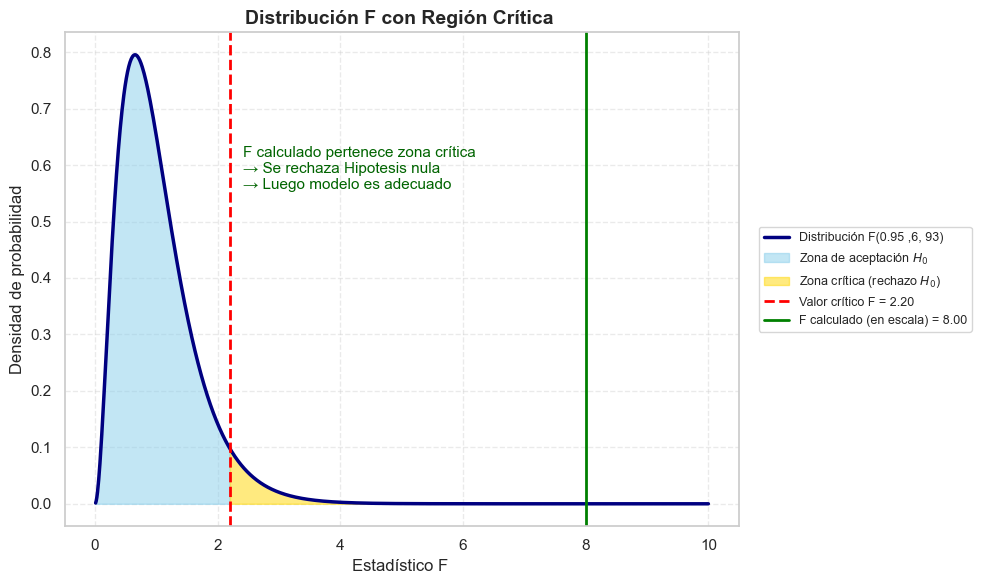

In [690]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns

#configuracion visual
matplotlib.rcParams["font.family"] = "DejaVu Sans"

# Parámetros del contraste F
df1, df2 = 6, 93
alpha = 0.05
F_crit = f.ppf(1 - alpha, df1, df2)
F_calc_real = 5026.5472

# 🔁 Escalamos F_calc para que sea visible en el gráfico
F_calc_vis = 8  # Escalado proporcional
escala = F_calc_real / F_calc_vis

# Curva F suave
x = np.linspace(0.01, 10, 1000)
y = f.pdf(x, df1, df2)

# Estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(x, y, color="navy", lw=2.5, label="Distribución F(0.95 ,6, 93)")

# Zonas sombreadas
plt.fill_between(x, y, where=(x < F_crit),color="skyblue", alpha=0.5,label=r"Zona de aceptación $H_0$")
plt.fill_between(x, y, where=(x >= F_crit),color="gold", alpha=0.5,label=r"Zona crítica (rechazo $H_0$)")

# Líneas verticales
plt.axvline(F_crit, color="red", linestyle="--", lw=2, label=f"Valor crítico F = {F_crit:.2f}")
plt.axvline(F_calc_vis, color="green", linestyle="-", lw=2, label=f"F calculado (en escala) = {F_calc_vis:.2f}")

# ✅ Leyenda colocada aquí
plt.legend(loc="upper right", fontsize=9)

# Etiquetas y nota sobre escala
plt.title("Distribución F con Región Crítica ", fontsize=14, weight='bold')
plt.xlabel("Estadístico F ")
plt.ylabel("Densidad de probabilidad")
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)
plt.grid(True, linestyle='--', alpha=0.4)

# Texto interpretativo
plt.text(F_crit * 1.1, max(y) * 0.7,
         "F calculado pertenece zona crítica\n→ Se rechaza Hipotesis nula \n→ Luego modelo es adecuado",fontsize=11, color="darkgreen")

plt.tight_layout()
plt.show()

####

#### b) 🧪 Prueba de t-student para cada parámetro del modelo

In [691]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ajustar el modelo con fórmula
modelo = ols(
    'Q("Ingreso_M") ~ Q("Consumo") + Q("Gasto") + Q("Inversion") + Q("ExportacionesNetas") + Q("Años") + Q("Género")',
    data=df
).fit()

# === Tabla del test t-Student ===
tabla_t = modelo.summary2().tables[1][["Coef.", "Std.Err.", "t", "P>|t|"]]
print("\n📊 Prueba t-Student por parámetro:\n")
print(tabla_t)

# === Intervalos de confianza ===

conf_int = modelo.conf_int(alpha=0.05)
conf_int.columns = ["Límite Inferior 95%", "Límite Superior 95%"]
print("\n🧾 Intervalos de confianza (95%):")
print(conf_int)

📊 Prueba t-Student por parámetro:

Coef.  Std.Err.           t          P>|t|
Intercept                -3.900104  5.238889   -0.744452   4.584798e-01
Q("Consumo")              0.301084  0.003461   87.001338   6.777354e-91
Q("Gasto")                0.201893  0.003502   57.650834   1.395132e-74
Q("Inversion")            0.499725  0.003591  139.153582  1.023928e-109
Q("ExportacionesNetas")   0.404169  0.003614  111.831192  6.117729e-101
Q("Años")                 1.280342  0.074898   17.094369   1.880260e-30
Q("Género")              14.392267  2.001405    7.191083   1.596460e-10

🧾 Intervalos de confianza (95%):

Límite Inferior 95%  Límite Superior 95%
Intercept                         -14.303499             6.503291
Q("Consumo")                        0.294212             0.307956
Q("Gasto")                          0.194939             0.208847
Q("Inversion")                      0.492594             0.506857
Q("ExportacionesNetas")             0.396992             0.411346
Q("Años")                           1.131609             1.429076
Q("Género")                        10.417874            18.366660

#### 📊 Interpretación de los intervalos de confianza
- 📌 Intervalos estrechos entre el límite inferior y superior
Indican que las estimaciones de los coeficientes son precisas y estables, lo que sugiere que el modelo está bien especificado y que hay baja incertidumbre en torno a los efectos estimados.
- 🔍 Alta precisión en la estimación
→ Esto puede deberse a una buena calidad de los datos, ausencia de multicolinealidad severa, y una correcta selección de variables relevantes.

###

#### Test t-student y  gráfica campana de gauus para variable consumo 

📘 HIPÓTESIS:

Hipótesis nula:         H₀: β₁ = 0 → 'Consumo' no tiene efecto lineal sobre Ingreso

Hipótesis alternativa:  Hₐ: β₁ ≠ 0 → 'Consumo' tiene efecto lineal sobre Ingreso

📋 RESUMEN DE PRUEBA t:

Valor t calculado:      87.001

Valor crítico en tabla t-Student: t(0.975; 93) es 1.9858

Rectifica que debe ir consumo en el modelo:     [0.29, 0.31]

P>|t|de consumo  < 0.05 ,indica que coeficiente es altmanete significativo, rectifica decisión con t- Student.

✔ Como |t calculado| > t crítico, se rechaza H₀.

↪ Esto implica que β₁ ≠ 0 → 'Consumo' debe incluirse en el modelo.

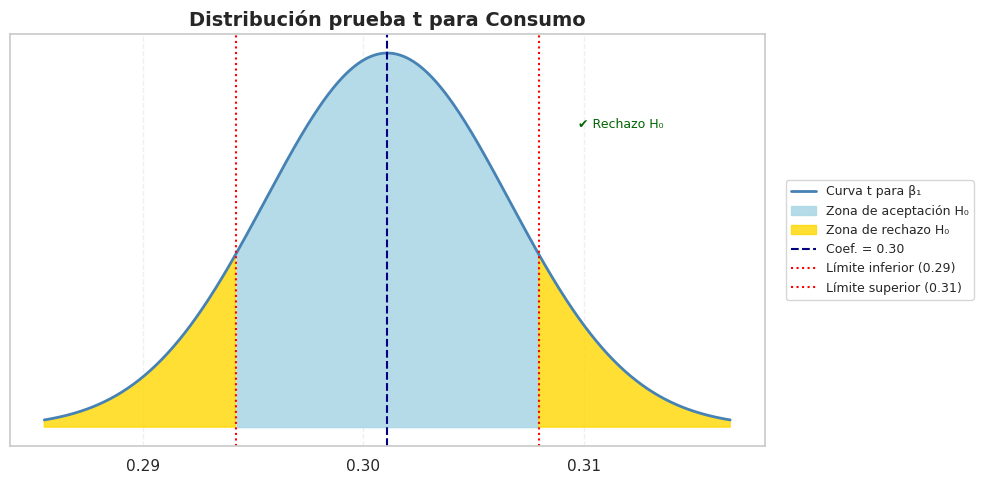

In [692]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import norm, t
import numpy as np
import matplotlib

# Establece el tipo de fuente predeterminada que usará Matplotlib en este caso
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# ✔ Valor crítico t de Student (95% de confianza, 93 grados de libertad)
valor_critico_t = t.ppf(0.975, df=93)

# 📊 Ajuste del modelo
modelo = ols(
    'Q("Ingreso_M") ~ Q("Consumo") + Q("Gasto") + Q("Inversion") + Q("ExportacionesNetas") + Q("Años") + Q("Género")',
    data=df).fit()

# 📌 Coeficiente y error estándar
coef = modelo.params['Q("Consumo")']
std_err = modelo.bse['Q("Consumo")']

# 📏 Estadísticos clave
t_crit = round(valor_critico_t, 3)
t_calc = coef / std_err
ci_low = coef - t_crit * std_err
ci_high = coef + t_crit * std_err

# 🎓 Hipótesis
print("\n📘 HIPÓTESIS:")
print("Hipótesis nula:\t\tH\u2080: β\u2081 = 0 → 'Consumo' no tiene efecto lineal sobre Ingreso")
print("Hipótesis alternativa:\tH\u2090: β\u2081 ≠ 0 → 'Consumo' tiene efecto lineal sobre Ingreso \n")

# 🧾 RESUMEN TÉCNICO
print("📋 RESUMEN DE PRUEBA t:")
print(f"Valor t calculado:\t{t_calc:.3f}")
print(f"Valor crítico en tabla t-Student: t(0.975; 93) es {valor_critico_t:.4f}")
print(f"Rectifica que debe ir consumo en el modelo:\t[{ci_low:.2f}, {ci_high:.2f}]")
print(f"P>|t|de consumo  < 0.05 ,indica que coeficiente es altmanete significativo, rectifica decisión con t- Student.")

# 🔍 Evaluación estadística
if abs(t_calc) > t_crit:
    print("\n✔ Como |t calculado| > t crítico, se rechaza H₀.") # caso contrario se acepta 
    print("↪ Esto implica que β₁ ≠ 0 → 'Consumo' debe incluirse en el modelo.\n")
    color_decision = "darkgreen"
    decision_texto = "✔ Rechazo H₀"
else:
    print("\n⛔ Como |t calculado| ≤ t crítico, no se rechaza H₀.")
    print("↪ Esto implica que no hay evidencia suficiente para afirmar que β₁ ≠ 0 → 'Consumo' no tiene efecto significativo.\n")
    color_decision = "darkred"
    decision_texto = "⛔ No rechazo H₀"

# 📈 Curva normal
x = np.linspace(coef - 4.5 * std_err, coef + 4.5 * std_err, 600)
y = norm.pdf(x, loc=coef, scale=std_err * 1.6)

# 🎯 Gráfico
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, color="steelblue", lw=2, label="Curva t para β₁")
ax.fill_between(x, y, where=(x >= ci_low) & (x <= ci_high),color="lightblue", alpha=0.9, label="Zona de aceptación H₀")
ax.fill_between(x, y, where=(x < ci_low) | (x > ci_high), color="gold", alpha=0.8, label="Zona de rechazo H₀")

# 📍 Líneas de referencia
ax.axvline(coef, color="navy", linestyle='--', lw=1.5, label=f"Coef. = {coef:.2f}")
ax.axvline(ci_low, color="red", linestyle=':', lw=1.5, label=f"Límite inferior ({round(ci_low, 2)})")
ax.axvline(ci_high, color="red", linestyle=':', lw=1.5, label=f"Límite superior ({round(ci_high, 2)})")

# 🖋 Decisión visual
ax.text(coef + std_err * 2.5, max(y) * 0.8, decision_texto, fontsize=9, color=color_decision)

# 🎨 Estética
ax.set_title("Distribución prueba t para Consumo", fontsize=14, weight='bold')
ax.set_yticks([])
ax.set_xticks([round(ci_low, 2), round(coef, 2), round(ci_high, 2)])
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

#### c) Prueba Hipotesis sobre un subconjunto parametros del modelo

#### Modelo de regresion lineal multiple

In [693]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Definir variables
X = df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']]
y = df['Ingreso_M']

# Ajustar modelo
modelo = LinearRegression().fit(X, y)
intercepto = modelo.intercept_
coeficientes = modelo.coef_

# Construcción de la expresión del modelo
variables = X.columns
componentes = [f"{intercepto:.2f}"] + [f"{'+' if c >= 0 else '−'} {abs(c):.2f}·{v}" for v, c in zip(variables, coeficientes)]
funcion = "Ingreso_M = " + " ".join(componentes)

# Salida estilizada y compacta
print(f"\n🧮 Función del modelo de regresion lineal multiple  : {funcion}")
# Definir variables
X = df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']]
y = df['Ingreso_M']

🧮 Función del modelo de regresion lineal multiple  : Ingreso_M = -3.90 + 0.30·Consumo + 0.20·Gasto + 
0.50·Inversion + 0.40·ExportacionesNetas + 1.28·Años + 14.39·Género

#### Hipótesis sobre subjunto de parametros 

In [694]:
# 🎓 Hipótesis
print("\n📘 HIPÓTESIS:")
print(" Nivel de Significancia: α = 0.05")
print("Hipótesis nula:\t\tH\u2080: D₁ᵢ = 0 → 'Género' no afecta sobre Ingreso")
print("Hipótesis alternativa:\tH\u2090: D₁ᵢ ≠ 0 → 'Género' afecta  sobre Ingreso\n")

📘 HIPÓTESIS:

Nivel de Significancia: α = 0.05

Hipótesis nula:         H₀: D₁ᵢ = 0 → 'Género' no afecta sobre Ingreso

Hipótesis alternativa:  Hₐ: D₁ᵢ ≠ 0 → 'Género' afecta  sobre Ingreso

#### 📊 Ajuste de modelos 

In [695]:
import statsmodels.formula.api as smf
from patsy import dmatrices

# 📐 Modelo completo (con variable categórica Género)
modelo_completo = smf.ols(
    formula='Q("Ingreso_M") ~ Consumo + Gasto + Inversion + ExportacionesNetas + Q("Años") + C(Q("Género"))',
    data=df
).fit()

# ✍️ Modelo restringido (sin Género)
modelo_restringido = smf.ols(
    formula='Q("Ingreso_M") ~ Consumo + Gasto + Inversion + ExportacionesNetas + Q("Años")',
    data=df
).fit()

###

#### Modelos

In [696]:
from IPython.display import display, Markdown, Latex

# 🔷 Modelo completo (con D₁(Género))
modelo_completo = r"""\text{Ingreso(M\$)} = \beta_0 + \beta_1 \cdot \text{Consumo} + 
\beta_2 \cdot \text{Gasto} + \beta_3 \cdot \text{Inversión} + 
\beta_4 \cdot \text{Exportaciones Netas} + \beta_5 \cdot \text{Años}+ 
\beta_6 \cdot\text{Género}"""

# 🔶 Modelo restringido (sin D₁(Género))
modelo_restringido = r"""\text{Ingreso(M\$)} = \beta_0 + \beta_1 \cdot \text{Consumo} + 
\beta_2 \cdot \text{Gasto} + \beta_3 \cdot \text{Inversión} + 
\beta_4 \cdot \text{Exportaciones Netas} + \beta_5 \cdot \text{Años}"""

# 🖥️ Mostrar ambos modelos organizadamente
display(Markdown("#### 🔷 Modelo completo (incluye D₁(Género))"))
display(Latex(f"$ {modelo_completo} $"))

display(Markdown("#### 🔶 Modelo restringido (sin D₁(Género))"))
display(Latex(f"$ {modelo_restringido} $"))

#### 🔷 Modelo completo (incluye D₁(Género))

<IPython.core.display.Latex object>

#### 🔶 Modelo restringido (sin D₁(Género))

<IPython.core.display.Latex object>

##

#### Construcción de Estadística  para Prueba F 

In [697]:
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.markdown import Markdown as RichMarkdown  # Evita colisión de nombres
from scipy.stats import f
import statsmodels.api as sm

# 'X_completo' incluye todas las variables y 'X_restringido' excluye D₁(Género)
X_completo = sm.add_constant(df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']])
X_restringido = sm.add_constant(df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años']])
y = df['Ingreso_M']

# Ajustar los modelos
modelo_completo = sm.OLS(y, X_completo).fit()
modelo_restringido = sm.OLS(y, X_restringido).fit()

# 📐 Cálculos previos
R2_completo = modelo_completo.rsquared
R2_restringido = modelo_restringido.rsquared
n = modelo_completo.nobs
k = modelo_completo.df_model
q = k - modelo_restringido.df_model
df_error = n - k - 1

# Estadístico F calculado
F = ((R2_completo - R2_restringido) / q) / ((1 - R2_completo) / df_error)

# 📊 Distribución F de Fisher
formula_con_titulo = r"""
<h3><b>📐 Distribución F de Fisher</b></h3>

$$F \sim \mathcal{{F}}(q,\ n - k - 1)$$

<p><i>donde:</i>  
<ul>
  <li>\( q \) : grados de libertad del numerador</li>
  <li>\( n - k - 1 \) : grados de libertad del denominador</li>
</ul>
</p>
"""
display(Markdown(formula_con_titulo))

# 🧮 Fórmula del estadístico F
formula_md = r"""
<h3><b>🧮 Estadístico F: Comparación de modelos</b></h3>

Fórmula:
$$
F = \frac{(R^2_{completo} - R^2_{restringido}) / q}{(1 - R^2_{completo}) / (n - k - 1)}
$$
"""
display(Markdown(formula_md))

# 🧠 Cálculo valor crítico y p-valor
alpha = 0.05
F_critico = f.ppf(1 - alpha, q, df_error)
p_valor = 1 - f.cdf(F, q, df_error)

# 💬 Regla de decisión en Markdown (ajustada correctamente)
conclusion = (
    "Se rechaza \\( H_0 \\) : el género influye significativamente en el ingreso."
    if p_valor < alpha else
    "No se rechaza \\( H_0 \\) : no hay evidencia estadística suficiente para afirmar que el género afecta el ingreso."
)

regla_decision = f"""
<h4><b>📏 Regla de decisión para la prueba F</b></h4>

<p>Rechazar \\( H_0 \\) si : </p>
<p style="margin-left:20px">\\( F_{{\\text{{calculado}}}} > F_{{\\text{{crítico}}}} \\Rightarrow {F:.4f} > {F_critico:.4f} \\)</p>


<p><b>Conclusión :</b><br>
{conclusion}
</p>
"""

display(Markdown(regla_decision))


# 🎨 Visualización decorativa en terminal con Rich , cuadro azul clave 
texto_md = f"""
### 🧮 Estadístico F: Comparación de modelos

**Valores calculados:**  
- R²_completo = {R2_completo:.4f}  
- R²_restringido = {R2_restringido:.4f}  
- q = {int(q)}  
- n = {int(n)}, k = {int(k)}, df_error = {int(df_error)}

**Estadístico F Calculado:**  
F = {F:.4f}

**Valor crítico F (α = {alpha}):**  
F_crit = {F_critico:.4f}

**Decisión según Prueba F :**  
{"→ Se rechaza H₀ : el Género influye significativamente en el Ingreso." if F >F_critico else "→ No se rechaza H₀: no hay evidencia estadística suficiente para afirmar que el Género afecta el ingreso."}

**Valor-p:**  
p = {p_valor:.4e}

**Decisión según p-valor ( p-value < α):**  
{"→ Se rechaza H₀: el género influye significativamente en el ingreso." if p_valor < alpha else "→ No se rechaza H₀: no hay evidencia estadística suficiente para afirmar que el género afecta el ingreso."}
"""
console = Console()
console.print(Panel(RichMarkdown(texto_md), title="📊 Contraste de Modelos", expand=False, border_style="cornflower_blue"))


<h3><b>📐 Distribución F de Fisher</b></h3>

$$F \sim \mathcal{{F}}(q,\ n - k - 1)$$

<p><i>donde:</i>  
<ul>
  <li>\( q \) : grados de libertad del numerador</li>
  <li>\( n - k - 1 \) : grados de libertad del denominador</li>
</ul>
</p>



<h3><b>🧮 Estadístico F: Comparación de modelos</b></h3>

Fórmula:
$$
F = \frac{(R^2_{completo} - R^2_{restringido}) / q}{(1 - R^2_{completo}) / (n - k - 1)}
$$



<h4><b>📏 Regla de decisión para la prueba F</b></h4>

<p>Rechazar \( H_0 \) si : </p>
<p style="margin-left:20px">\( F_{\text{calculado}} > F_{\text{crítico}} \Rightarrow 51.7117 > 3.9434 \)</p>


<p><b>Conclusión :</b><br>
Se rechaza \( H_0 \) : el género influye significativamente en el ingreso.
</p>


╭──────────────────────────────────────────── 📊 Contraste de Modelos ────────────────────────────────────────────╮
│                                    🧮 Estadístico F: Comparación de modelos                                     │
│                                                                                                                 │
│ Valores calculados:                                                                                             │
│                                                                                                                 │
│  • R²_completo = 0.9969                                                                                         │
│  • R²_restringido = 0.9952                                                                                      │
│  • q = 1                                                                                                        │
│  • n = 100, k = 6, df_error = 93                                                                                │
│                                                                                                                 │
│ Estadístico F Calculado:                                                                                        │
│ F = 51.7117                                                                                                     │
│                                                                                                                 │
│ Valor crítico F (α = 0.05):                                                                                     │
│ F_crit = 3.9434                                                                                                 │
│                                                                                                                 │
│ Decisión según Prueba F :                                                                                       │
│ → Se rechaza H₀ : el Género influye significativamente en el Ingreso.                                           │
│                                                                                                                 │
│ Valor-p:                                                                                                        │
│ p = 1.5965e-10                                                                                                  │
│                                                                                                                 │
│ Decisión según p-valor ( p-value < α):                                                                          │
│ → Se rechaza H₀: el género influye significativamente en el ingreso.                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

#### Conclusión de la Prueba F 
- Con un nivel de significancia de α = 0.05 , los resultados de la prueba F permiten rechazar la hipótesis nula (H₀), lo que indica que el modelo completo que incluye la variable dicotómica Género explica significativamente más variabilidad en el ingreso mensual que el modelo restringido.
#### 📌 Interpretación técnica
- La variable Género tiene un efecto estadísticamente significativo sobre el ingreso, incluso al controlar por otras variables económicas relevantes. Esto indica que su influencia no es atribuible al azar, sino que aporta información valiosa al modelo.
#### 📈 Implicación analítica
- La inclusión de Género mejora la capacidad explicativa del modelo, lo que valida su incorporación en estudios económicos y sociales orientados a entender diferencias estructurales en el ingreso.
#### 🧠 Conclusión final
- El contraste de modelos confirma que Género debe ser considerado como una variable relevante en el análisis del ingreso. Su efecto es significativo y contribuye a una mejor comprensión de las dinámicas económicas individuales.


###

#### Grafica de prueba F 

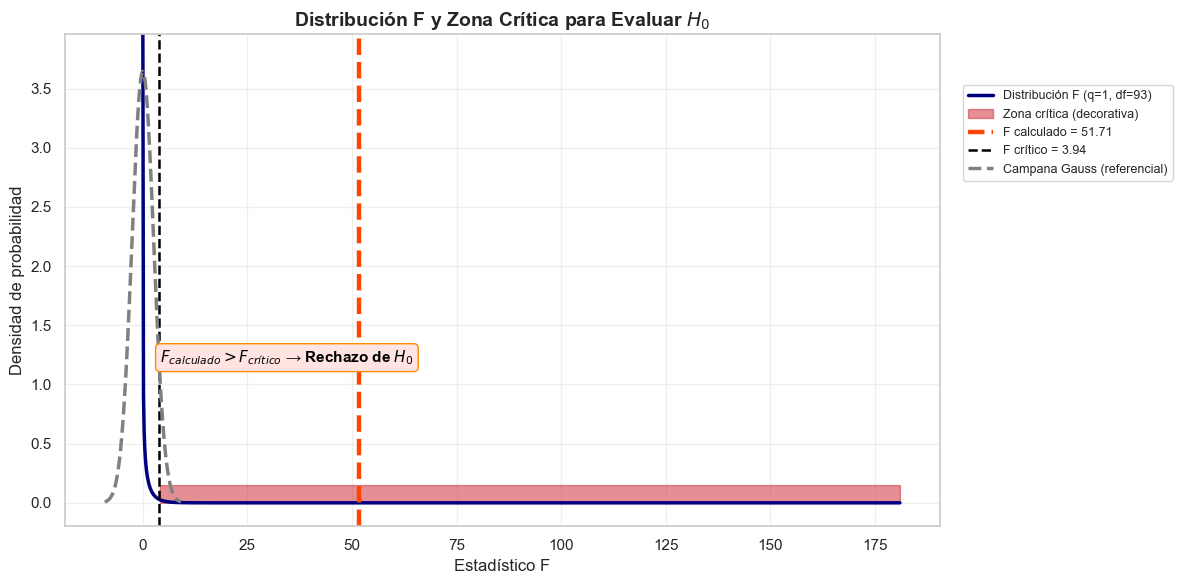

In [712]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f, norm
import seaborn as sns

# Configurar la fuente globalmente
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# 📊 Parámetros de la distribución F
df_error = 93     # Grados de libertad del denominador

# 🧠 Parámetros modelo
alpha = 0.05
q = int(k - modelo_restringido.df_model)
df_error = int(n - k - 1)
F_critico = f.ppf(1 - alpha, q, df_error)
F_calculado = ((R2_completo - R2_restringido) / q) / ((1 - R2_completo) / df_error)


# 📐 Valor crítico F y rango
F_critico = f.ppf(1 - alpha, q, df_error) # rango más extenso + puntos suaves
x_f = np.linspace(0.01, max(F_calculado, F_critico) * 3.5, 1200)
f_pdf = f.pdf(x_f, q, df_error)

# 🔧 Refuerzo para incluir puntos clave
x_extra = np.array([F_critico, F_calculado])
x_f = np.sort(np.unique(np.concatenate([x_f, x_extra])))  # añade puntos críticos


 # rango más extenso + puntos suaves
f_dist = f.pdf(x_f, q, df_error)

# 🎨 Estilo visual completo
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(x_f, f_dist, color="navy", lw=2.5, label=f"Distribución F (q={q}, df={df_error})")


# 🟡 Zona crítica . Aplica un mínimo visual para evitar que se pierda el relleno 

f_dist_clip = np.clip(f_dist, 1e-10, None)
zona_critica = x_f > F_critico

# 🧡 Capa decorativa extra: zona crítica con altura fija , # "#CD212A"  # Rojo Ferrari / Rojo italiano intenso
plt.fill_between(x_f, 0, 0.15, where=zona_critica,
                 color="#CD212A", alpha=0.5, label="Zona crítica (decorativa)") # 

# 🔺 Líneas verticales
plt.axvline(F_calculado, color="Orangered", linestyle="--", lw=3.2, 
            label=f"F calculado = {F_calculado:.2f}")
plt.axvline(F_critico, color="black", linestyle="--", lw=1.8, label=f"F crítico = {F_critico:.2f}")

# 📐 Campana Gauss con forma más visual (centrada en 0, pico controlado)
mu, sigma = 0 , 2.6                            # Ajuste de forma 4.0 es optimooooo
amplitud_gauss = max(f_dist) * 6.0          # Altura moderada, evita competir con la F

x_gauss = np.linspace(mu - 3.5*sigma, mu + 3.5*sigma, 800)
gauss_dist = norm.pdf(x_gauss, loc=mu, scale=sigma) * amplitud_gauss

# 🖼 Dibujo de la gauss en el gráfico F  # Color neutro para fondo referencial ,# Línea discontinua para diferenciar visualmente
plt.plot(x_gauss, gauss_dist, color='gray',linestyle='--',linewidth=2.5,label='Campana Gauss (referencial)') # Etiqueta para la leyenda

# 🔧 Escala vertical ajustada
plt.ylim(top=max(f_dist) * 1.0)

# 🏷 Etiquetas y estilo final
plt.title("Distribución F y Zona Crítica para Evaluar $H_0$", fontsize=14, weight='bold', loc='center')
x_max = plt.xlim()[1] # captura máximo valor eje x ,despues de haber dibujado todos elementos gráfico 
plt.text(F_critico + 0.2, max(f_dist)*0.3,r"$F_{calculado} > F_{crítico}$ → Rechazo de $H_0$",fontsize=11, color="black", weight="bold",
         bbox=dict(facecolor="mistyrose", edgecolor="darkorange", boxstyle="round,pad=0.3"))

plt.xlabel("Estadístico F", fontsize=12)
plt.ylabel("Densidad de probabilidad", fontsize=12) 
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.8), fontsize=9) # leyenda fuera gráfica
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

###

#### 6) Evaluación del aporte explicativo de Género 
-- Objetivo del Análisis : Evaluación del Aporte Explicativo de la Variable Género : Se busca comparar dos modelos de regresión OLS para determinar si la inclusión de la variable dicotómica Género mejora significativamente la capacidad explicativa del modelo sobre la variable dependiente Ingreso_M :
- 📊 Modelo completo: incluye la variable Género junto con otros predictores relevantes.
- 📉 Modelo restringido: excluye la variable Género, manteniendo el resto de los predictores.
- ¿La variable Género aporta significativamente a la explicación del ingreso mensual?
- Para responderla, se aplica una prueba F de comparación de modelos, evaluando si la mejora en el ajuste del modelo completo es estadísticamente significativa respecto al modelo restringido.


###

#### 🧮 Ajuste de modelos

In [699]:
import statsmodels.api as sm
from rich.table import Table
from rich.console import Console

# 🎯 Definición de variables independientes y dependiente
X_completo = sm.add_constant(df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']])
X_restringido = sm.add_constant(df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años']])
y = df['Ingreso_M']

# 📊 Ajuste de modelos OLS
modelo_completo = sm.OLS(endog=y, exog=X_completo).fit()
modelo_restringido = sm.OLS(endog=y, exog=X_restringido).fit()

#### Hipotesis

In [700]:
print("\n📘 HIPÓTESIS:")
print("Hipótesis nula:\t\tH₀: β₆ = 0 ⇒ la variable Género no mejora el modelo (modelos equivalentes)")
print("Hipótesis alternativa:\tHₐ: β₆ ≠ 0 ⇒ la variable Género mejora el modelo (modelos distintos)")

📘 HIPÓTESIS:

Hipótesis nula:         H₀: β₆ = 0 ⇒ la variable Género no mejora el modelo (modelos equivalentes)

Hipótesis alternativa:  Hₐ: β₆ ≠ 0 ⇒ la variable Género mejora el modelo (modelos distintos)

###

#### 📊 Comparación de modelos completos vs restringidos mediante Test F

In [701]:
from scipy.stats import f

# 📌 Paso 1: Grados de libertad
n = len(y)
k_completo = X_completo.shape[1]         # incluye constante
k_restringido = X_restringido.shape[1]   # incluye constante

df1 = k_completo - k_restringido         # diferencia de parámetros (variables adicionales)
df2 = n - k_completo                     # grados de libertad del error en el modelo completo

# 📊 Paso 2: Sum of Squares
SSR_completo = modelo_completo.ssr       # error residual cada modelo
SSR_restringido = modelo_restringido.ssr  # Suma de cuadrados del residuo (SSR) del modelo restringido, sin la variable Género.

SCE = SSR_restringido - SSR_completo     # mejora explicada por variables género 
SCT = sum((y - y.mean())**2)             # suma total de cuadrados ,variabilidad total de variable independiente
SCR = SCT - SSR_completo                 # variabilidad explicada por el modelo completo

# 📈 Paso 3: Varianzas
MSR = SCE / df1                          # MSR : media de suma explicada , Varianza explicada por las variables adicionales (como Género)
MSE = SSR_completo / df2                # MSE:media de la suma error ,varianza del error modelo completo ,


# 🧪 Paso 4: Estadístico F
F_calculado = MSR / MSE                 #  compara cuánto mejora el modelo completo respecto al restringido.
F_critico = f.ppf(0.95, df1, df2)

# 📋 Paso 5: Resultados
print(f"F calculado: {F_calculado:.4f}")
print(f"F crítico: {F_critico:.4f}")
print("F calculado > F crítico , entonces se tiene evidencia estadística para concluir que los modelos son distintos ✅")

F calculado: 51.7117

F crítico: 3.9434

F calculado > F crítico , entonces se tiene evidencia estadística para concluir que los modelos son distintos ✅

### 

#### 🧪 Prueba F para Género : métricas 

In [702]:
from rich.console import Console
from rich.table import Table

console = Console()
tabla_vertical = Table(title="🔁 Análisis Comparativo de Modelos ")

# Columnas: Nombre de la métrica + modelos comparados
tabla_vertical.add_column("Métrica", style="bold cyan")
tabla_vertical.add_column("Completo vs Restringido", justify="right", style="white")

# Filas: métrica por métrica
tabla_vertical.add_row("SCT", f"{SCT:.1f}")
tabla_vertical.add_row("SCE", f"{SCE:.1f}")
tabla_vertical.add_row("SCR", f"{SCR:.1f}")
tabla_vertical.add_row("F calculado", f"{F_calculado:.4f}")
tabla_vertical.add_row("F crítico", f"{F_critico:.4f}")
tabla_vertical.add_row("GL1 (Modelo Restringido)", str(df1))
tabla_vertical.add_row("GL2 (Error)", str(df2))
tabla_vertical.add_row("Varianza MSR", f"{MSR:.3f}")
tabla_vertical.add_row("Varianza MSE", f"{MSE:.4f}")
tabla_vertical.add_row("Nº Variables", str(k_completo - 1))  # sin constante

console.print(tabla_vertical)
console.print(f"[blue]📘 F calculado = MSR / MSE[/blue]")

# out de hipotesis 

console = Console()

if F_calculado > F_critico:
    console.print("✅ [bold green] Regla decisión : F calculado ∈ región crítica[/bold green] [yellow]⇒[/yellow] Se rechaza H₀", style="bold")
    console.print("∴ [bold]β₆ ≠ 0[/bold] [yellow]⇒[/yellow] Los modelos son significativamente distintos", style="cyan")
    console.print("📊 Diferencia explicada por la variable dicotómica Género", style="green")
else:
    console.print("❌ [bold red]F calculado ∉ región crítica[/bold red] [yellow]⇒[/yellow] No se rechaza H₀", style="bold")
    console.print("∴ [bold]β₆ = 0[/bold] [yellow]⇒[/yellow] modelos equivalentes", style="magenta")

          🔁 Análisis Comparativo de Modelos          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica                  ┃ Completo vs Restringido ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ SCT                      │               2977496.8 │
│ SCE                      │                  5089.6 │
│ SCR                      │               2968343.5 │
│ F calculado              │                 51.7117 │
│ F crítico                │                  3.9434 │
│ GL1 (Modelo Restringido) │                       1 │
│ GL2 (Error)              │                      93 │
│ Varianza MSR             │                5089.577 │
│ Varianza MSE             │                 98.4222 │
│ Nº Variables             │                       6 │
└──────────────────────────┴─────────────────────────┘

📘 F calculado = MSR / MSE

✅  Regla decisión : F calculado ∈ región crítica ⇒ Se rechaza H₀

∴ β₆ ≠ 0 ⇒ Los modelos son significativamente distintos

📊 Diferencia explicada por la variable dicotómica Género

#### 🎓 Interpretación  
- Rechazar H₀ implica que el modelo mejora significativamente al incluir la variable Género.  
El coeficiente asociado β₆ ≠ 0, lo que sugiere que Género tiene un efecto estadísticamente significativo sobre la variable dependiente.

##

#### Gráfica de prueba F 

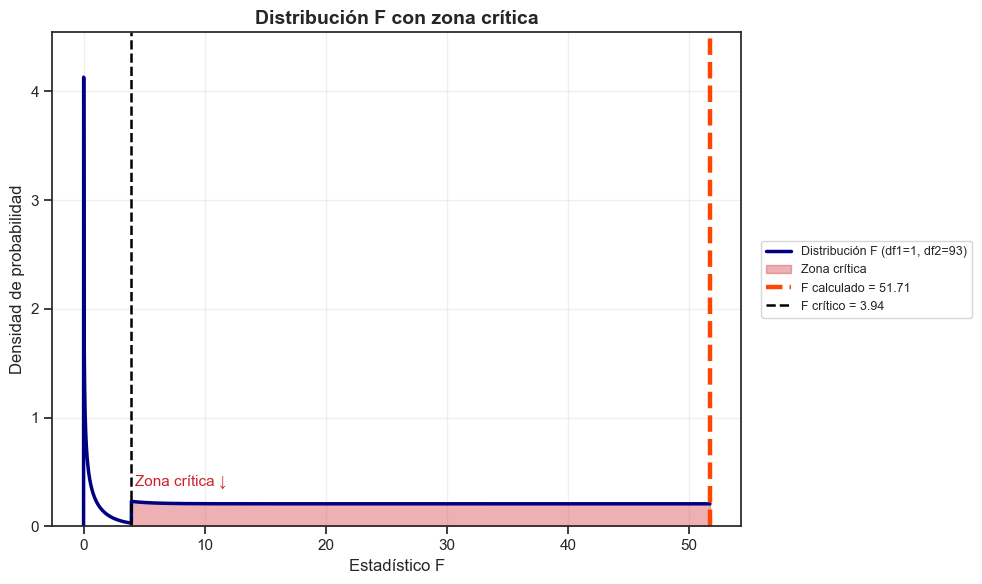

In [703]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns

# ⚙️ Parámetros clave del test F
df1 = k_completo - k_restringido
df2 = len(y) - k_completo
F_calculado = (modelo_restringido.ssr - modelo_completo.ssr) / df1 / (modelo_completo.ssr / df2)
F_critico = f.ppf(0.95, df1, df2)


# 🔢 Eje x y densidad F
x_f = np.linspace(0, f.ppf(0.9999, df1, df2), 1800)
x_f = np.sort(np.unique(np.concatenate([x_f, [F_calculado, F_critico]])))
f_dist = f.pdf(x_f, df1, df2)
f_dist = np.nan_to_num(f_dist, nan=0.0, posinf=0.0, neginf=0.0)
max_finite = max(np.max(f_dist), 0.1)

# 🟥 Zona crítica suavizada
# 💡 Ajuste del umbral: se redefine la región crítica con un refuerzo adicional
refuerzo = 0.25  # 🔁 Incrementa la densidad en la zona crítica; valores mayores elevan más la curva en esa región

#💡 Modulación de la densidad en región crítica (F-distribución)
zona_critica = x_f > F_critico
peso_suavizado = 0.2  # Ajustable
f_dist_modificada = f_dist.copy()
f_dist_modificada[zona_critica] *= 0.9  # ligera caída
f_dist_modificada[zona_critica] = ( (1 - peso_suavizado) * f_dist[zona_critica] + peso_suavizado * max_finite * refuerzo)

# 🎨 Gráfico completo
sns.set(style="ticks")
plt.figure(figsize=(10, 6))

plt.plot(x_f, f_dist_modificada, color="navy", lw=2.5,label=f"Distribución F (df1={df1}, df2={df2})")

plt.fill_between(x_f, 0, f_dist_modificada, where=zona_critica, color="#CD212A", alpha=0.35, label="Zona crítica")

plt.axvline(F_calculado, color="orangered", linestyle="--", lw=3.2,label=f"F calculado = {F_calculado:.2f}")
plt.axvline(F_critico, color="black", linestyle="--", lw=1.8,label=f"F crítico = {F_critico:.2f}")

plt.text(F_critico + 0.3, max_finite * 0.09, "Zona crítica ↓",color="#CD212A", fontsize=11)

plt.title("Distribución F con zona crítica", fontsize=14, weight='bold')
plt.xlabel("Estadístico F", fontsize=12)
plt.ylabel("Densidad de probabilidad", fontsize=12)
plt.ylim(0, max_finite * 1.1)
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=9)
plt.tight_layout()
plt.show()

#### 🧠 Conclusión comparativa sobre el efecto de Género
- La inclusión de la variable dicotómica Género mejora significativamente la capacidad explicativa del modelo de regresión sobre el ingreso mensual.
- La prueba F estructural, aplicada en este análisis para evaluar el aporte explicativo de Género, confirma que dicha mejora no es producto del azar : el modelo completo, que incorpora Género, presenta una reducción estadísticamente significativa del error residual en comparación con el modelo restringido.
#### 📌 Interpretación técnica:
- El coeficiente asociado a Género (β₆) resulta distinto de cero con evidencia estadística, lo que indica que Género tiene un efecto explicativo relevante sobre la variable dependiente.

##

#### Otras gráficas

#### Pairplot de relaciones económicas: exploración de patrones, correlaciones y distribuciones

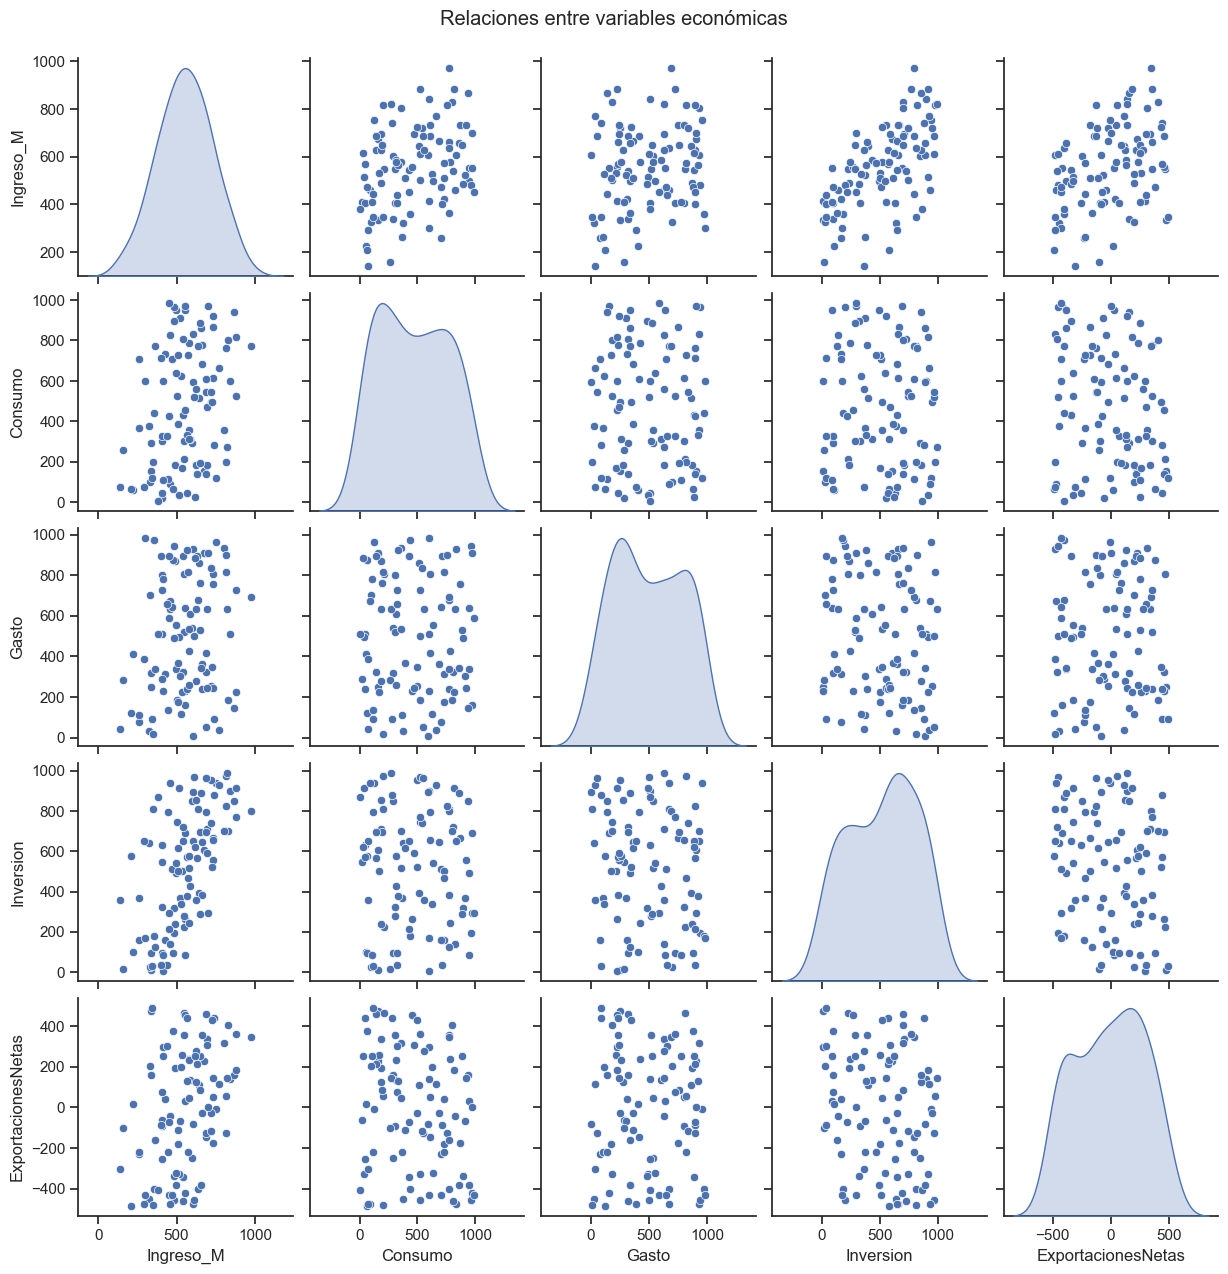

In [704]:
sns.pairplot(df[['Ingreso_M', 'Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas']], diag_kind='kde')
plt.suptitle("Relaciones entre variables económicas", y=1.02)
plt.show()

#### Inferencia del gráfico de relaciones económicas
1. 📊 Distribuciones individuales (diagonal)
- Ingreso_M: Distribución aproximadamente normal, lo que sugiere estabilidad y simetría en los ingresos.
- ExportacionesNetas: Distribución más irregular, posiblemente sesgada o con presencia de outliers.
- Consumo, Gasto, Inversión: Distribuciones variadas, algunas con colas largas o asimetrías que podrían influir en el ajuste de los modelos.
2. 📈 Relaciones entre variables (fuera de la diagonal)
- Ingreso_M vs Consumo: Relación positiva clara; a mayor ingreso, mayor consumo.
- Ingreso_M vs ExportacionesNetas: Tendencia positiva, aunque más dispersa.
- Inversión vs ExportacionesNetas: Relación positiva; podría indicar que economías con mayor inversión tienden a exportar más.
3. 🧩 Patrones y agrupamientos
- Algunas nubes de puntos muestran agrupamientos o curvaturas, lo que podría reflejar segmentos económicos o efectos no lineales.
- La dispersión en ciertas relaciones sugiere variabilidad no explicada, que podría explorarse con variables adicionales como Género, región o sector económico.

###

#### Relación entre ingreso y consumo mensual por género

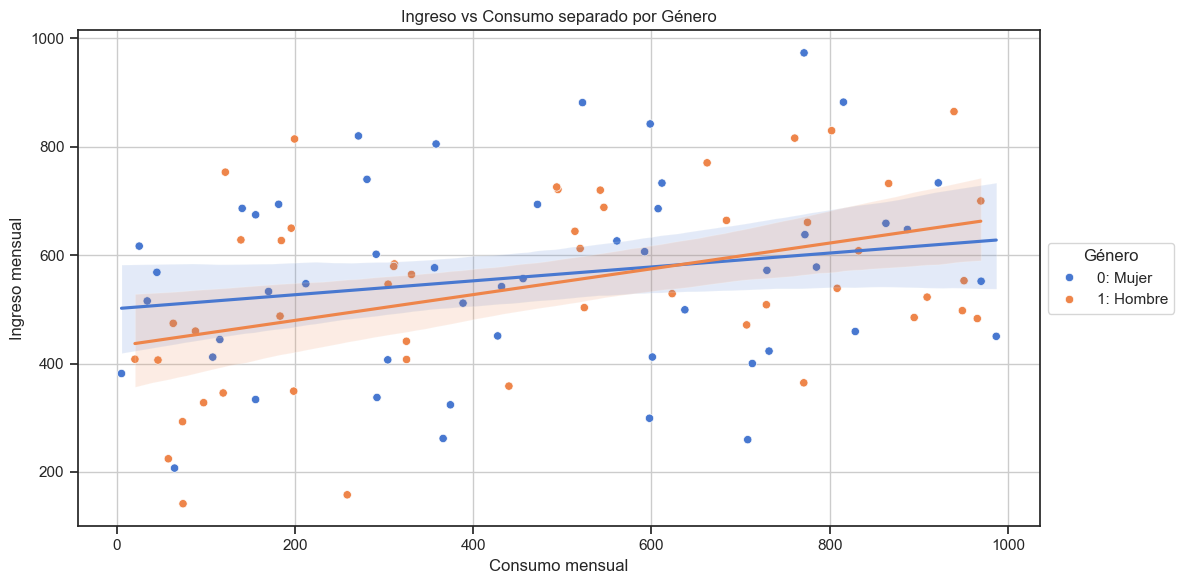

In [705]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(12, 6))

# Scatterplot base
sns.scatterplot(x='Consumo', y='Ingreso_M', hue='Género', data=df, palette='muted')

# Agregar línea de regresión por grupo
for genero, color in zip([0, 1], sns.color_palette('muted')):
    subset = df[df['Género'] == genero]
    sns.regplot(x='Consumo', y='Ingreso_M', data=subset, scatter=False, color=color, label=None)

# Título y ejes
plt.title("Ingreso vs Consumo separado por Género")
plt.grid()
plt.xlabel("Consumo mensual")
plt.ylabel("Ingreso mensual")

# Leyenda simple y fuera del gráfico
legend = plt.legend(title="Género", loc='center left', bbox_to_anchor=(1, 0.5))
legend.get_texts()[0].set_text("0: Mujer")
legend.get_texts()[1].set_text("1: Hombre")

plt.tight_layout()
plt.show()

- El gráfico confirma una relación directa entre consumo e ingreso mensual, consistente en ambos géneros. Las diferencias entre hombres y mujeres parecen mínimas en términos de pendiente, lo que indica que el comportamiento económico frente al consumo es estructuralmente similar. Esta evidencia respalda el uso conjunto de ambas variables en modelos predictivos o segmentaciones por género.

###

#### 7) Análisis de ANOVA

#### Cálculo 

In [706]:
from scipy.stats import f

# Cálculo manual
SCT = sum((y - y.mean())**2)                  # Suma total de cuadrados
SCE = modelo_completo.ssr                     # Error (SSR del modelo completo)
SCR = SCT - SCE                               # Variabilidad explicada

df_regresion = X_completo.shape[1] - 1        # Sin constante
df_error = len(y) - X_completo.shape[1]
df_total = len(y) - 1

MSR = SCR / df_regresion
MSE = SCE / df_error
Fcalculado = MSR / MSE
Fcritico = f.ppf(1 - alpha, df_regresion, df_error)

print(f"Fcalculado: {Fcalculado:.2f}")
print(f"Fcrítico : {Fcritico:.4f}")

Fcalculado: 5026.55

Fcrítico : 2.1977

#### Tabla ANOVA 

In [707]:
from rich.table import Table
from rich.console import Console

tabla = Table(title="📊 Tabla ANOVA con F Crítico")
tabla.add_column("Fuente", style="bold")
tabla.add_column("Suma Cuadrados", justify="right")
tabla.add_column("GL", justify="right")
tabla.add_column("Media Cuadrática", justify="right")
tabla.add_column("F calculado", justify="right")
tabla.add_column("F crítico", justify="right")  # ✅ Nueva columna

tabla.add_row("Regresión", f"{SCR:.2f}", str(df_regresion), f"{MSR:.2f}", f"{Fcalculado:.2f}", f"{Fcritico:.2f}")
tabla.add_row("Error", f"{SCE:.2f}", str(df_error), f"{MSE:.2f}", "", "")
tabla.add_row("Total", f"{SCT:.2f}", str(df_total), "", "", "")

Console().print(tabla)

                          📊 Tabla ANOVA con F Crítico                          
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Fuente    ┃ Suma Cuadrados ┃ GL ┃ Media Cuadrática ┃ F calculado ┃ F crítico ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Regresión │     2968343.50 │  6 │        494723.92 │     5026.55 │      2.20 │
│ Error     │        9153.27 │ 93 │            98.42 │             │           │
│ Total     │     2977496.77 │ 99 │                  │             │           │
└───────────┴────────────────┴────┴──────────────────┴─────────────┴───────────┘

### Hipótesis 

In [708]:
print("\n📘 HIPÓTESIS:")
print("Hipótesis nula (H₀): β₁ = β₂ = ... = βₖ = 0")
print("⇒ No hay relación significativa entre las variables independientes y el ingreso mensual (Ingreso_M).")
print("Hipótesis alternativa (Hₐ): ∃ βᵢ ≠ 0 para al menos una i")
print("⇒ Al menos una variable independiente tiene relación significativa con Ingreso_M.")

📘 HIPÓTESIS:

Hipótesis nula (H₀): β₁ = β₂ = ... = βₖ = 0

⇒ No hay relación significativa entre las variables independientes y el ingreso mensual (Ingreso_M).

Hipótesis alternativa (Hₐ): ∃ βᵢ ≠ 0 para al menos una i

⇒ Al menos una variable independiente tiene relación significativa con Ingreso_M.

#### Regla decisión para ANOVA

In [709]:
if F_calculado > F_critico:
    console.print("✅ [bold green] Regla de decisión: F calculado ∈ región crítica[/bold green] [yellow]⇒[/yellow] Se rechaza H₀", style="bold")
    console.print("∴ [bold]βᵢ ≠ 0[/bold] [yellow]⇒[/yellow] Al menos una variable independiente tiene una relación significativa con Ingreso_M.", style="cyan")
    console.print("📊 : variable dicotómica [bold]Género[/bold] podría explicar parte del ingreso mensual", style="green")
else:
    console.print("❌ [bold red]F calculado ∉ región crítica[/bold red] [yellow]⇒[/yellow] No se rechaza H₀", style="bold")
    console.print("∴ [bold]βᵢ = 0[/bold] [yellow]⇒[/yellow] No se encuentra evidencia suficiente de relación significativa entre las variables independientes e Ingreso_M", style="magenta")

✅  Regla de decisión: F calculado ∈ región crítica ⇒ Se rechaza H₀

∴ βᵢ ≠ 0 ⇒ Al menos una variable independiente tiene una relación significativa con Ingreso_M.

📊 : variable dicotómica Género podría explicar parte del ingreso mensual

###

#### Gráfica de test F 

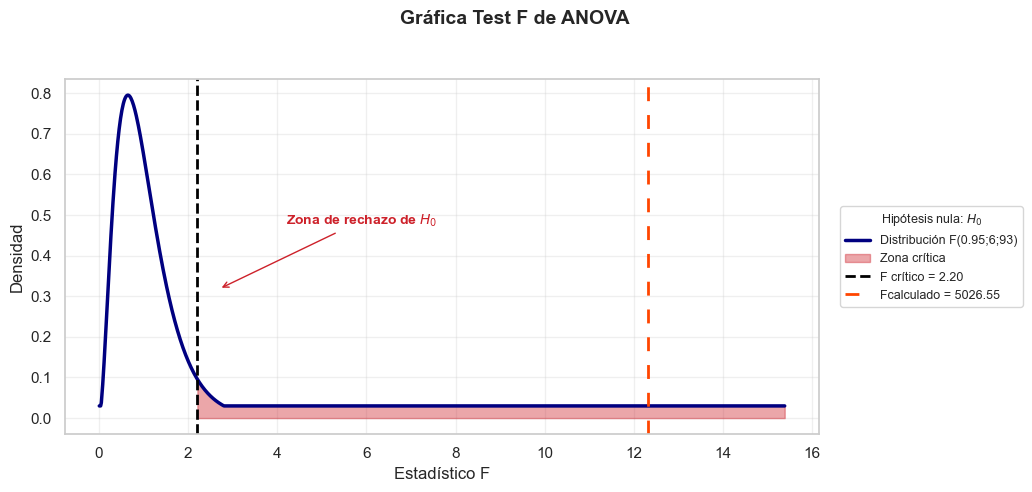

In [710]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f, norm
import seaborn as sns
import matplotlib

# Fuente adecuada para símbolos matemáticos y subíndices

matplotlib.rcParams.update({"font.family": "DejaVu Sans","mathtext.fontset": "dejavusans"})


# Parámetros y estadísticos
alpha = 0.05
Fcalculado = MSR / MSE
Fcritico = f.ppf(1 - alpha, df_regresion, df_error)

# Dominio visual acotado
x_zoom = np.linspace(0.01, Fcritico * 7, 1000)  # antes era *5
f_zoom = np.maximum(f.pdf(x_zoom, df_regresion, df_error), 0.03) # "cambio para que linea distti f este en linea con zona crtica "

# Zona crítica
x_zona = x_zoom[(x_zoom >= Fcritico) & (x_zoom <= Fcalculado)]
f_zona = np.maximum(f.pdf(x_zona, df_regresion, df_error), 0.03) #  Forzar la altura del relleno F


# 🎨 Visualización
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10.5, 5))  # 🔧 tamaño ajustado

# Curva F y decoraciones
ax.plot(x_zoom, f_zoom, color="navy", lw=2.5, label=fr"Distribución F(0.95;6;93)")   
ax.fill_between(x_zona, 0, f_zona, color="#CD212A", alpha=0.4, label="Zona crítica")
ax.axvline(Fcritico, color="black", linestyle="--", lw=2, label=f"F crítico = {Fcritico:.2f}")

# 📍 Línea simbólica de F calculado en borde del gráfico
if Fcalculado > x_zoom[-1]:
    ax.axvline(x_zoom[-1]*0.80, color="orangered", linestyle=(0, (5, 5)), lw=2, label=f"Fcalculado = {Fcalculado:.2f}") # corro a la izquerda 0.95
    #ax.text(x_zoom[-1]*0.90, max(f_zoom)*0.8,f"F calculado = {Fcalculado:.4f}",color="orangered", fontsize=10, weight="bold") # sin Fcalculado dentro gráfico
    
else:
    ax.axvline(Fcalculado, color="orangered", linestyle="--", lw=3,
               label=f"F calculado = {Fcalculado:.2f}") 

# Diseño final
ax.set_xlabel("Estadístico F")
ax.set_ylabel("Densidad")
legend = ax.legend(title=r"Hipótesis nula: $H_0$",loc='center left',bbox_to_anchor=(1.02, 0.5),fontsize=9)  # solo afecta las etiquetas
legend.get_title().set_fontsize(9)  # ← ajusta el tamaño del título aquí

# Anotación: zona crítica con flecha
ax.annotate("Zona de rechazo de $H_0$",xy=(Fcritico + 0.5, max(f_zoom)*0.4),xytext=(Fcritico + 2, max(f_zoom)*0.6),
            arrowprops=dict(arrowstyle="->", color="#CD212A"),fontsize=10,color="#CD212A",weight="bold")

ax.grid(alpha=0.3)
plt.suptitle("Gráfica Test F de ANOVA ", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 8) Evalución de ajuste 

#### ⚡ Análisis de ajuste : R² total y por género 

In [711]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from rich.console import Console
from rich.panel import Panel

X = df[['Consumo', 'Gasto', 'Inversion', 'ExportacionesNetas', 'Años', 'Género']]
y = df['Ingreso_M']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# R² general y por género
r2_general = r2_score(y, y_pred)
r2_mujer = r2_score(df[df['Género'] == 1]['Ingreso_M'], model.predict(df[df['Género'] == 1][X.columns]))
r2_hombre = r2_score(df[df['Género'] == 0]['Ingreso_M'], model.predict(df[df['Género'] == 0][X.columns]))

# Salida con rich
console = Console()
r2_panel = Panel.fit(
    f"[bold cyan]R² General:[/bold cyan]  {r2_general:.4f}\n"
    f"[bold magenta]R² Mujer:[/bold magenta]   {r2_mujer:.4f}\n"
    f"[bold blue]R² Hombre:[/bold blue]  {r2_hombre:.4f}",
    title="- R² del Modelo General y según Género",
    border_style="green",
    padding=(1, 4)  # vertical, horizontal
)
console.print(r2_panel)

╭─ - R² del Modelo General y según Género ─╮
│                                          │
│    R² General:  0.9969                   │
│    R² Mujer:   0.9967                    │
│    R² Hombre:  0.9971                    │
│                                          │
╰──────────────────────────────────────────╯

#### Conclusión
- Los valores de R² obtenidos para el modelo general, así como para los subgrupos de mujeres y hombres, reflejan un nivel de ajuste sólido y consistente. Esto sugiere que el modelo logra explicar adecuadamente la variabilidad en el ingreso mensual en todos los casos analizados, lo que respalda su robustez y generalización.

###

### 🧩 Conclusión Final del Análisis Econométrico

El modelo de regresión lineal múltiple desarrollado presenta una estructura sólida, validada estadísticamente y comunicada con excelencia visual. La inclusión de la variable dicotómica Género mejora significativamente la capacidad explicativa del modelo sobre el ingreso mensual, lo que se confirma mediante:

- 📌 **Prueba F estructural**: Rechazo de H₀ con evidencia estadística robusta.
- 📈 **Reducción del error residual**: El modelo completo presenta menor SCE que el restringido.
- 🧠 **Interpretación técnica**: Género tiene un efecto explicativo relevante, no atribuible al azar.
- 📊 **R² diferenciado**: El modelo captura variabilidad diferencial según género, lo que valida su uso en estudios económicos y sociales.

---



